# **Import Libraries**

In [1]:
# 🚨 Warnings
import warnings

# 🔢 Standard Libraries
import copy
import math
import pickle
import random

# 📊 Data Manipulation
import numpy as np
import pandas as pd

# 🧪 PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# 🖼️ Torchvision (Optional Transforms)
from torchvision import transforms

# ⏳ Progress Bar
from tqdm import tqdm

# 🧠 Sklearn Tools
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 📈 Plotting
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# **Ignore Warnings**

In [2]:
# Ignoring any warning messages
warnings.filterwarnings('ignore')

# **Create Custom Dataset**

In [3]:
class MatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        return x, y

# **Load Dataset**

In [29]:
# Load Train Data
with open("/kaggle/input/data-prep-2/train_data.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

# Load Val Data
with open("/kaggle/input/data-prep-2/val_data.pkl", "rb") as f:
    X_val, y_val = pickle.load(f)

X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)

# **Apply Transformations**

In [5]:
# Flatten for scaler
N, T, F = X_train.shape
X_train_2d = X_train.reshape(-1, F)
X_val_2d = X_val.reshape(-1, F)

# Remove subset of outliers by clipping at percentiles (e.g., 5st and 95th)
lower_percentile = 5
upper_percentile = 95

lower_bounds = np.percentile(X_train_2d, lower_percentile, axis=0)
upper_bounds = np.percentile(X_train_2d, upper_percentile, axis=0)

# Clip train and val features to these bounds to remove extreme outliers
X_train_2d_clipped = np.clip(X_train_2d, lower_bounds, upper_bounds)
X_val_2d_clipped = np.clip(X_val_2d, lower_bounds, upper_bounds)

# Fit scaler on clipped train data
scaler = RobustScaler()
scaler.fit(X_train_2d_clipped)

# Transform clipped train and val data
X_train = scaler.transform(X_train_2d_clipped).reshape(N, T, F)
X_val = scaler.transform(X_val_2d_clipped).reshape(X_val.shape)

# **Encode Labels**

In [6]:
# Create label set and mapping
classes = sorted(set(y_train))
label_map = {l: i for i, l in enumerate(classes)}

# One-hot encode
y_train_encoded = torch.nn.functional.one_hot(torch.tensor([label_map[l] for l in y_train]), num_classes=len(classes)).float()
y_val_encoded   = torch.nn.functional.one_hot(torch.tensor([label_map[l] for l in y_val]), num_classes=len(classes)).float()

# **Create Dataloaders**

In [7]:
# Create datasets
train_dataset = MatrixDataset(X_train, y_train_encoded)
val_dataset   = MatrixDataset(X_val,   y_val_encoded)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader   = DataLoader(val_dataset,   batch_size = 128, shuffle = False)

 # **Create Positional Encoding**

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

# **Create Layer Normalization**

In [9]:
class LayerNormalization(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.eps = eps
        
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.bias  = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std  = x.std( dim = -1, keepdim = True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

# **Create Position-wise Feedforward Network**

In [10]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
    super().__init__()
    self.d_model = d_model
    self.d_ff = d_ff

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

    self.linear_1 = nn.Linear(self.d_model, self.d_ff)
    self.linear_2 = nn.Linear(self.d_ff, self.d_model)

  def forward(self, x):
    x = self.linear_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear_2(x)
    return x

# **Create Multihead Attention**

In [11]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float) -> None:
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, "d_model isn't divisible by h"

    self.d_k = d_model // h

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
      attention_scores.masked_fill_(mask == 0, -1e9)
    attention_scores = attention_scores.softmax(dim = -1)

    if dropout:
      attention_scores = dropout(attention_scores)

    return (attention_scores @ value), attention_scores

  def forward(self, q, k, v, mask):
    query  = self.w_q(q)
    key    = self.w_k(k)
    value  = self.w_v(v)

    query  = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
    key    = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value  = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

    x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.d_model)

    return self.w_o(x)

# **Create Residual Connection**

In [12]:
class ResidualConnection(nn.Module):
  def __init__(self, d_model: int, dropout: float) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization(d_model)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

# **Create Encoder**

In [13]:
class SingleEncoderBlock(nn.Module):
  def __init__(self, d_model: int, multiHeadAttention: MultiHeadAttention, feedForwardNetwork: FeedForwardNetwork, dropout: float) -> None:
    super().__init__()
    self.multiHeadAttention  = multiHeadAttention
    self.feedForwardNetwork   = feedForwardNetwork
    self.residualConnections = nn.ModuleList([ResidualConnection(d_model, dropout) for _ in range(2)])

  def forward(self, x, mask):
    x = self.residualConnections[0](x, lambda x : self.multiHeadAttention(x, x, x, mask))
    x = self.residualConnections[1](x, self.feedForwardNetwork)
    return x

In [14]:
class Encoder(nn.Module):
  def __init__(self, d_model: int, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm   = LayerNormalization(d_model)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

# **Create Transformer**

In [15]:
class Transformer(nn.Module):
    def __init__(self, seq_len: int, d_model: int, dropout: float, nhead: int, d_ff: int, N: int) -> None:
        super().__init__()
        self.input_proj        = nn.Linear(54, d_model)
        self.d_model           = d_model
        self.postionalEncoding = PositionalEncoding(d_model, seq_len, dropout)
        multiHeadAttention     = MultiHeadAttention(d_model, nhead, dropout)
        feedForwardNetwork     = FeedForwardNetwork(d_model, d_ff, dropout)
        encoders               = nn.ModuleList([SingleEncoderBlock(d_model, multiHeadAttention, feedForwardNetwork, dropout) for _ in range(N)])
        self.transformer       = Encoder(d_model, encoders)
        self.classifier        = nn.Linear(d_model, 10)
                                 
    def forward(self, x, mask = None):
        x = self.input_proj(x)
        x = self.postionalEncoding(x)
        x = self.transformer(x, mask = None)
        x = x.mean(dim = 1)
        x = self.classifier(x)
        return x

# **Training Loop**

In [16]:
import torch
import torch.nn as nn
from tqdm import tqdm
import copy

def train(model, train_dataloader, val_dataloader, epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

    best_val_loss = float('inf')
    best_model_state = None

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss_train = 0
        total_correct_train = 0
        total_samples_train = 0

        for train_sequence, train_label in tqdm(train_dataloader, desc=f'Epoch {epoch+1}'):
            train_sequence = train_sequence.to(device)
            train_label = train_label.to(device)

            train_label_indices = torch.argmax(train_label, dim=1)

            optimizer.zero_grad()
            predictions = model(train_sequence)
            loss = criterion(predictions, train_label_indices)

            predicted_classes = torch.argmax(predictions, dim=1)
            correct = (predicted_classes == train_label_indices).sum().item()
            total_correct_train += correct
            total_samples_train += train_label.size(0)
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        scheduler.step()

        train_loss_avg = total_loss_train / len(train_dataloader)
        train_acc_avg = total_correct_train / total_samples_train

        model.eval()
        total_loss_val = 0
        total_correct_val = 0
        total_samples_val = 0

        with torch.no_grad():
            for val_sequence, val_label in val_dataloader:
                val_sequence = val_sequence.to(device)
                val_label = val_label.to(device)
                
                val_label_indices = torch.argmax(val_label, dim=1)

                predictions = model(val_sequence)
                loss = criterion(predictions, val_label_indices)

                predicted_classes = torch.argmax(predictions, dim=1)
                correct = (predicted_classes == val_label_indices).sum().item()
                total_correct_val += correct
                total_samples_val += val_label.size(0)
                total_loss_val += loss.item()

        val_loss_avg = total_loss_val / len(val_dataloader)
        val_acc_avg = total_correct_val / total_samples_val

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc_avg)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc_avg)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc_avg:.4f}')
        print(f'Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc_avg:.4f}')
        print(f'Current LR: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, 'best_model.pt')

    # 🔁 Load the best model before returning
    if best_model_state:
        model.load_state_dict(torch.load('best_model.pt'))

    return train_losses, val_losses, train_accuracies, val_accuracies

# **Training all Transformer models**

In [17]:
# -------------------------------
# Set Random Seeds for Reproducibility
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Ensure reproducibility
# -------------------------------

# Training all Transformer models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Transformer variants
models = [
    Transformer(180, 64, 0.1, 8, 32, 2),
    Transformer(180, 64, 0.1, 8, 32, 1),
    Transformer(180, 64, 0.1, 8, 64, 2),
    Transformer(180, 64, 0.1, 8, 64, 1),
    Transformer(180, 32, 0.1, 8, 32, 2),
    Transformer(180, 32, 0.1, 8, 32, 1),
    Transformer(180, 64, 0.1, 16, 64, 2),
    Transformer(180, 64, 0.1, 16, 64, 1),
    Transformer(180, 32, 0.1, 16, 32, 2),
    Transformer(180, 32, 0.1, 16, 32, 1),
]

# Train all models
for i, model in enumerate(models):
    print(f"\n🚀 Training model {i+1}/{len(models)}")
    train(model, train_loader, val_loader, epochs=30, lr=0.01)

# Set models to eval
for model in models:
    model.eval()


🚀 Training model 1/10


Epoch 1: 100%|██████████| 170/170 [00:05<00:00, 29.62it/s]


Epoch 1/30
Train Loss: 1.5387 | Train Acc: 0.6410
Val Loss: 1.7140 | Val Acc: 0.5807
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 2/30
Train Loss: 1.2508 | Train Acc: 0.8131
Val Loss: 1.6973 | Val Acc: 0.6080
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:04<00:00, 34.17it/s]


Epoch 3/30
Train Loss: 1.1648 | Train Acc: 0.8572
Val Loss: 1.6860 | Val Acc: 0.6364
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:04<00:00, 34.19it/s]


Epoch 4/30
Train Loss: 1.1034 | Train Acc: 0.8925
Val Loss: 1.7081 | Val Acc: 0.6083
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 5/30
Train Loss: 1.0795 | Train Acc: 0.9034
Val Loss: 1.6643 | Val Acc: 0.6411
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:04<00:00, 34.14it/s]


Epoch 6/30
Train Loss: 1.0590 | Train Acc: 0.9144
Val Loss: 1.7237 | Val Acc: 0.6163
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 7/30
Train Loss: 1.0327 | Train Acc: 0.9267
Val Loss: 1.6534 | Val Acc: 0.6407
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:04<00:00, 34.13it/s]


Epoch 8/30
Train Loss: 0.9717 | Train Acc: 0.9607
Val Loss: 1.7100 | Val Acc: 0.6116
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:04<00:00, 34.18it/s]


Epoch 9/30
Train Loss: 0.9572 | Train Acc: 0.9692
Val Loss: 1.6525 | Val Acc: 0.6369
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:04<00:00, 34.13it/s]


Epoch 10/30
Train Loss: 0.9526 | Train Acc: 0.9701
Val Loss: 1.6838 | Val Acc: 0.6426
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:04<00:00, 34.15it/s]


Epoch 11/30
Train Loss: 0.9490 | Train Acc: 0.9714
Val Loss: 1.6773 | Val Acc: 0.6401
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:04<00:00, 34.08it/s]


Epoch 12/30
Train Loss: 0.9436 | Train Acc: 0.9732
Val Loss: 1.7200 | Val Acc: 0.6270
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:04<00:00, 34.18it/s]


Epoch 13/30
Train Loss: 0.9386 | Train Acc: 0.9754
Val Loss: 1.7192 | Val Acc: 0.6262
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:04<00:00, 34.15it/s]


Epoch 14/30
Train Loss: 0.9411 | Train Acc: 0.9739
Val Loss: 1.6311 | Val Acc: 0.6743
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 15/30
Train Loss: 0.9107 | Train Acc: 0.9886
Val Loss: 1.6750 | Val Acc: 0.6477
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:04<00:00, 34.14it/s]


Epoch 16/30
Train Loss: 0.9072 | Train Acc: 0.9904
Val Loss: 1.6549 | Val Acc: 0.6609
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 17/30
Train Loss: 0.9065 | Train Acc: 0.9903
Val Loss: 1.6746 | Val Acc: 0.6481
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:04<00:00, 34.09it/s]


Epoch 18/30
Train Loss: 0.9030 | Train Acc: 0.9909
Val Loss: 1.6981 | Val Acc: 0.6469
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 19/30
Train Loss: 0.9030 | Train Acc: 0.9910
Val Loss: 1.7254 | Val Acc: 0.6271
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:04<00:00, 34.13it/s]


Epoch 20/30
Train Loss: 0.9019 | Train Acc: 0.9916
Val Loss: 1.7045 | Val Acc: 0.6469
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:04<00:00, 34.15it/s]


Epoch 21/30
Train Loss: 0.9047 | Train Acc: 0.9897
Val Loss: 1.7131 | Val Acc: 0.6346
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:04<00:00, 34.16it/s]


Epoch 22/30
Train Loss: 0.8920 | Train Acc: 0.9953
Val Loss: 1.6831 | Val Acc: 0.6534
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:04<00:00, 34.13it/s]


Epoch 23/30
Train Loss: 0.8882 | Train Acc: 0.9967
Val Loss: 1.6742 | Val Acc: 0.6493
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:04<00:00, 34.11it/s]


Epoch 24/30
Train Loss: 0.8877 | Train Acc: 0.9970
Val Loss: 1.6670 | Val Acc: 0.6642
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:04<00:00, 34.18it/s]


Epoch 25/30
Train Loss: 0.8869 | Train Acc: 0.9972
Val Loss: 1.6731 | Val Acc: 0.6680
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:04<00:00, 34.17it/s]


Epoch 26/30
Train Loss: 0.8880 | Train Acc: 0.9965
Val Loss: 1.6900 | Val Acc: 0.6557
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:04<00:00, 34.14it/s]


Epoch 27/30
Train Loss: 0.8864 | Train Acc: 0.9971
Val Loss: 1.7066 | Val Acc: 0.6405
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:04<00:00, 34.19it/s]


Epoch 28/30
Train Loss: 0.8869 | Train Acc: 0.9971
Val Loss: 1.7009 | Val Acc: 0.6512
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:04<00:00, 34.11it/s]


Epoch 29/30
Train Loss: 0.8820 | Train Acc: 0.9987
Val Loss: 1.6702 | Val Acc: 0.6624
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:04<00:00, 34.11it/s]


Epoch 30/30
Train Loss: 0.8814 | Train Acc: 0.9985
Val Loss: 1.7262 | Val Acc: 0.6381
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 2/10


Epoch 1: 100%|██████████| 170/170 [00:02<00:00, 62.14it/s]


Epoch 1/30
Train Loss: 1.5112 | Train Acc: 0.6587
Val Loss: 1.7711 | Val Acc: 0.5560
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:02<00:00, 62.06it/s]


Epoch 2/30
Train Loss: 1.2447 | Train Acc: 0.8177
Val Loss: 1.7606 | Val Acc: 0.5823
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:02<00:00, 62.13it/s]


Epoch 3/30
Train Loss: 1.1575 | Train Acc: 0.8643
Val Loss: 1.7778 | Val Acc: 0.5987
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:02<00:00, 62.12it/s]


Epoch 4/30
Train Loss: 1.1135 | Train Acc: 0.8870
Val Loss: 1.8114 | Val Acc: 0.5696
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:02<00:00, 62.07it/s]


Epoch 5/30
Train Loss: 1.0735 | Train Acc: 0.9093
Val Loss: 1.7916 | Val Acc: 0.5915
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:02<00:00, 62.03it/s]


Epoch 6/30
Train Loss: 1.0628 | Train Acc: 0.9133
Val Loss: 1.7150 | Val Acc: 0.6227
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:02<00:00, 62.23it/s]


Epoch 7/30
Train Loss: 1.0441 | Train Acc: 0.9227
Val Loss: 1.7550 | Val Acc: 0.5979
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:02<00:00, 62.15it/s]


Epoch 8/30
Train Loss: 0.9879 | Train Acc: 0.9549
Val Loss: 1.7529 | Val Acc: 0.6267
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:02<00:00, 61.78it/s]


Epoch 9/30
Train Loss: 0.9734 | Train Acc: 0.9642
Val Loss: 1.7907 | Val Acc: 0.6007
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:02<00:00, 62.09it/s]


Epoch 10/30
Train Loss: 0.9689 | Train Acc: 0.9657
Val Loss: 1.7373 | Val Acc: 0.6174
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:02<00:00, 62.11it/s]


Epoch 11/30
Train Loss: 0.9683 | Train Acc: 0.9663
Val Loss: 1.7824 | Val Acc: 0.6136
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:02<00:00, 61.92it/s]


Epoch 12/30
Train Loss: 0.9628 | Train Acc: 0.9699
Val Loss: 1.7725 | Val Acc: 0.6171
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:02<00:00, 62.11it/s]


Epoch 13/30
Train Loss: 0.9627 | Train Acc: 0.9689
Val Loss: 1.7630 | Val Acc: 0.6183
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:02<00:00, 62.07it/s]


Epoch 14/30
Train Loss: 0.9590 | Train Acc: 0.9700
Val Loss: 1.7400 | Val Acc: 0.6209
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:02<00:00, 61.94it/s]


Epoch 15/30
Train Loss: 0.9334 | Train Acc: 0.9844
Val Loss: 1.7346 | Val Acc: 0.6382
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:02<00:00, 62.08it/s]


Epoch 16/30
Train Loss: 0.9278 | Train Acc: 0.9866
Val Loss: 1.7696 | Val Acc: 0.6236
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:02<00:00, 61.98it/s]


Epoch 17/30
Train Loss: 0.9266 | Train Acc: 0.9871
Val Loss: 1.7400 | Val Acc: 0.6334
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:02<00:00, 62.08it/s]


Epoch 18/30
Train Loss: 0.9245 | Train Acc: 0.9882
Val Loss: 1.7257 | Val Acc: 0.6381
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:02<00:00, 61.77it/s]


Epoch 19/30
Train Loss: 0.9257 | Train Acc: 0.9878
Val Loss: 1.7763 | Val Acc: 0.6119
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:02<00:00, 62.16it/s]


Epoch 20/30
Train Loss: 0.9245 | Train Acc: 0.9885
Val Loss: 1.7877 | Val Acc: 0.6174
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:02<00:00, 61.35it/s]


Epoch 21/30
Train Loss: 0.9221 | Train Acc: 0.9902
Val Loss: 1.7575 | Val Acc: 0.6280
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:02<00:00, 62.07it/s]


Epoch 22/30
Train Loss: 0.9119 | Train Acc: 0.9936
Val Loss: 1.7342 | Val Acc: 0.6340
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:02<00:00, 62.12it/s]


Epoch 23/30
Train Loss: 0.9087 | Train Acc: 0.9948
Val Loss: 1.7402 | Val Acc: 0.6381
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:02<00:00, 62.09it/s]


Epoch 24/30
Train Loss: 0.9087 | Train Acc: 0.9948
Val Loss: 1.7582 | Val Acc: 0.6373
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:02<00:00, 61.92it/s]


Epoch 25/30
Train Loss: 0.9078 | Train Acc: 0.9958
Val Loss: 1.7490 | Val Acc: 0.6376
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:02<00:00, 61.95it/s]


Epoch 26/30
Train Loss: 0.9089 | Train Acc: 0.9939
Val Loss: 1.7330 | Val Acc: 0.6420
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:02<00:00, 62.11it/s]


Epoch 27/30
Train Loss: 0.9070 | Train Acc: 0.9948
Val Loss: 1.7482 | Val Acc: 0.6338
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:02<00:00, 61.98it/s]


Epoch 28/30
Train Loss: 0.9068 | Train Acc: 0.9953
Val Loss: 1.7287 | Val Acc: 0.6396
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:02<00:00, 61.94it/s]


Epoch 29/30
Train Loss: 0.9017 | Train Acc: 0.9963
Val Loss: 1.7339 | Val Acc: 0.6401
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:02<00:00, 62.13it/s]


Epoch 30/30
Train Loss: 0.9009 | Train Acc: 0.9968
Val Loss: 1.7199 | Val Acc: 0.6429
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 3/10


Epoch 1: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 1/30
Train Loss: 1.5166 | Train Acc: 0.6536
Val Loss: 1.7596 | Val Acc: 0.5684
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 2/30
Train Loss: 1.2270 | Train Acc: 0.8236
Val Loss: 1.7959 | Val Acc: 0.5636
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:05<00:00, 33.79it/s]


Epoch 3/30
Train Loss: 1.1396 | Train Acc: 0.8714
Val Loss: 1.7684 | Val Acc: 0.6106
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:05<00:00, 33.82it/s]


Epoch 4/30
Train Loss: 1.0915 | Train Acc: 0.8968
Val Loss: 1.6962 | Val Acc: 0.6098
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:05<00:00, 33.72it/s]


Epoch 5/30
Train Loss: 1.0668 | Train Acc: 0.9080
Val Loss: 1.7660 | Val Acc: 0.5953
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 6/30
Train Loss: 1.0378 | Train Acc: 0.9256
Val Loss: 1.7123 | Val Acc: 0.6220
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:05<00:00, 33.72it/s]


Epoch 7/30
Train Loss: 1.0246 | Train Acc: 0.9318
Val Loss: 1.7282 | Val Acc: 0.6306
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:05<00:00, 33.72it/s]


Epoch 8/30
Train Loss: 0.9654 | Train Acc: 0.9638
Val Loss: 1.7423 | Val Acc: 0.6020
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:05<00:00, 33.75it/s]


Epoch 9/30
Train Loss: 0.9541 | Train Acc: 0.9679
Val Loss: 1.7270 | Val Acc: 0.6253
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:05<00:00, 33.68it/s]


Epoch 10/30
Train Loss: 0.9470 | Train Acc: 0.9713
Val Loss: 1.7156 | Val Acc: 0.6197
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:05<00:00, 33.57it/s]


Epoch 11/30
Train Loss: 0.9490 | Train Acc: 0.9712
Val Loss: 1.7182 | Val Acc: 0.6264
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:05<00:00, 33.59it/s]


Epoch 12/30
Train Loss: 0.9439 | Train Acc: 0.9723
Val Loss: 1.7227 | Val Acc: 0.6250
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:05<00:00, 33.65it/s]


Epoch 13/30
Train Loss: 0.9349 | Train Acc: 0.9761
Val Loss: 1.7101 | Val Acc: 0.6332
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:05<00:00, 33.79it/s]


Epoch 14/30
Train Loss: 0.9354 | Train Acc: 0.9756
Val Loss: 1.7137 | Val Acc: 0.6315
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:05<00:00, 33.77it/s]


Epoch 15/30
Train Loss: 0.9082 | Train Acc: 0.9890
Val Loss: 1.7058 | Val Acc: 0.6385
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 16/30
Train Loss: 0.9002 | Train Acc: 0.9931
Val Loss: 1.7529 | Val Acc: 0.6168
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:05<00:00, 33.71it/s]


Epoch 17/30
Train Loss: 0.9015 | Train Acc: 0.9912
Val Loss: 1.7401 | Val Acc: 0.6171
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:05<00:00, 33.81it/s]


Epoch 18/30
Train Loss: 0.8980 | Train Acc: 0.9930
Val Loss: 1.6772 | Val Acc: 0.6525
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 19/30
Train Loss: 0.9025 | Train Acc: 0.9908
Val Loss: 1.7427 | Val Acc: 0.6303
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:05<00:00, 33.77it/s]


Epoch 20/30
Train Loss: 0.9004 | Train Acc: 0.9915
Val Loss: 1.7489 | Val Acc: 0.6209
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:05<00:00, 33.80it/s]


Epoch 21/30
Train Loss: 0.9021 | Train Acc: 0.9905
Val Loss: 1.7716 | Val Acc: 0.6210
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:05<00:00, 33.70it/s]


Epoch 22/30
Train Loss: 0.8887 | Train Acc: 0.9963
Val Loss: 1.7112 | Val Acc: 0.6402
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 23/30
Train Loss: 0.8853 | Train Acc: 0.9971
Val Loss: 1.7044 | Val Acc: 0.6461
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 24/30
Train Loss: 0.8858 | Train Acc: 0.9972
Val Loss: 1.7302 | Val Acc: 0.6385
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 25/30
Train Loss: 0.8847 | Train Acc: 0.9975
Val Loss: 1.6992 | Val Acc: 0.6557
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:05<00:00, 33.76it/s]


Epoch 26/30
Train Loss: 0.8850 | Train Acc: 0.9971
Val Loss: 1.7134 | Val Acc: 0.6509
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 27/30
Train Loss: 0.8858 | Train Acc: 0.9967
Val Loss: 1.7436 | Val Acc: 0.6320
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:05<00:00, 33.74it/s]


Epoch 28/30
Train Loss: 0.8865 | Train Acc: 0.9966
Val Loss: 1.7235 | Val Acc: 0.6417
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 29/30
Train Loss: 0.8805 | Train Acc: 0.9985
Val Loss: 1.7321 | Val Acc: 0.6352
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:05<00:00, 33.78it/s]


Epoch 30/30
Train Loss: 0.8796 | Train Acc: 0.9988
Val Loss: 1.7316 | Val Acc: 0.6419
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 4/10


Epoch 1: 100%|██████████| 170/170 [00:02<00:00, 61.53it/s]


Epoch 1/30
Train Loss: 1.5207 | Train Acc: 0.6517
Val Loss: 1.7359 | Val Acc: 0.5917
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:02<00:00, 61.35it/s]


Epoch 2/30
Train Loss: 1.2456 | Train Acc: 0.8148
Val Loss: 1.7502 | Val Acc: 0.5864
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:02<00:00, 61.44it/s]


Epoch 3/30
Train Loss: 1.1612 | Train Acc: 0.8633
Val Loss: 1.7555 | Val Acc: 0.5824
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:02<00:00, 61.51it/s]


Epoch 4/30
Train Loss: 1.1104 | Train Acc: 0.8882
Val Loss: 1.7441 | Val Acc: 0.5899
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:02<00:00, 61.33it/s]


Epoch 5/30
Train Loss: 1.0745 | Train Acc: 0.9098
Val Loss: 1.7331 | Val Acc: 0.6230
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:02<00:00, 61.08it/s]


Epoch 6/30
Train Loss: 1.0488 | Train Acc: 0.9250
Val Loss: 1.7407 | Val Acc: 0.6023
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:02<00:00, 61.47it/s]


Epoch 7/30
Train Loss: 1.0278 | Train Acc: 0.9352
Val Loss: 1.7343 | Val Acc: 0.5964
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:02<00:00, 61.36it/s]


Epoch 8/30
Train Loss: 0.9801 | Train Acc: 0.9621
Val Loss: 1.7445 | Val Acc: 0.6198
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:02<00:00, 61.59it/s]


Epoch 9/30
Train Loss: 0.9655 | Train Acc: 0.9703
Val Loss: 1.7484 | Val Acc: 0.6182
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:02<00:00, 61.54it/s]


Epoch 10/30
Train Loss: 0.9622 | Train Acc: 0.9713
Val Loss: 1.8220 | Val Acc: 0.5914
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:02<00:00, 61.49it/s]


Epoch 11/30
Train Loss: 0.9609 | Train Acc: 0.9701
Val Loss: 1.7407 | Val Acc: 0.6118
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:02<00:00, 61.32it/s]


Epoch 12/30
Train Loss: 0.9611 | Train Acc: 0.9704
Val Loss: 1.7159 | Val Acc: 0.6159
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:02<00:00, 61.42it/s]


Epoch 13/30
Train Loss: 0.9543 | Train Acc: 0.9735
Val Loss: 1.7800 | Val Acc: 0.6043
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:02<00:00, 61.52it/s]


Epoch 14/30
Train Loss: 0.9543 | Train Acc: 0.9746
Val Loss: 1.7801 | Val Acc: 0.6087
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:02<00:00, 61.47it/s]


Epoch 15/30
Train Loss: 0.9267 | Train Acc: 0.9873
Val Loss: 1.7418 | Val Acc: 0.6206
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:02<00:00, 61.31it/s]


Epoch 16/30
Train Loss: 0.9213 | Train Acc: 0.9893
Val Loss: 1.7856 | Val Acc: 0.6183
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:02<00:00, 61.53it/s]


Epoch 17/30
Train Loss: 0.9191 | Train Acc: 0.9908
Val Loss: 1.7515 | Val Acc: 0.6139
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:02<00:00, 61.42it/s]


Epoch 18/30
Train Loss: 0.9206 | Train Acc: 0.9903
Val Loss: 1.6900 | Val Acc: 0.6353
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:02<00:00, 61.53it/s]


Epoch 19/30
Train Loss: 0.9189 | Train Acc: 0.9910
Val Loss: 1.7870 | Val Acc: 0.6195
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:02<00:00, 61.49it/s]


Epoch 20/30
Train Loss: 0.9193 | Train Acc: 0.9907
Val Loss: 1.8237 | Val Acc: 0.6060
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:02<00:00, 61.34it/s]


Epoch 21/30
Train Loss: 0.9182 | Train Acc: 0.9906
Val Loss: 1.7685 | Val Acc: 0.6183
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:02<00:00, 61.47it/s]


Epoch 22/30
Train Loss: 0.9073 | Train Acc: 0.9950
Val Loss: 1.7510 | Val Acc: 0.6204
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:02<00:00, 61.52it/s]


Epoch 23/30
Train Loss: 0.9032 | Train Acc: 0.9969
Val Loss: 1.7690 | Val Acc: 0.6159
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:02<00:00, 61.39it/s]


Epoch 24/30
Train Loss: 0.9045 | Train Acc: 0.9959
Val Loss: 1.7616 | Val Acc: 0.6175
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:02<00:00, 61.59it/s]


Epoch 25/30
Train Loss: 0.9041 | Train Acc: 0.9963
Val Loss: 1.7535 | Val Acc: 0.6241
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:02<00:00, 61.10it/s]


Epoch 26/30
Train Loss: 0.9032 | Train Acc: 0.9966
Val Loss: 1.7269 | Val Acc: 0.6262
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:02<00:00, 61.58it/s]


Epoch 27/30
Train Loss: 0.9027 | Train Acc: 0.9966
Val Loss: 1.7661 | Val Acc: 0.6227
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:02<00:00, 61.48it/s]


Epoch 28/30
Train Loss: 0.9031 | Train Acc: 0.9969
Val Loss: 1.7879 | Val Acc: 0.6119
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:02<00:00, 61.56it/s]


Epoch 29/30
Train Loss: 0.8980 | Train Acc: 0.9977
Val Loss: 1.7501 | Val Acc: 0.6232
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:02<00:00, 61.47it/s]


Epoch 30/30
Train Loss: 0.8969 | Train Acc: 0.9979
Val Loss: 1.7607 | Val Acc: 0.6235
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 5/10


Epoch 1: 100%|██████████| 170/170 [00:04<00:00, 37.88it/s]


Epoch 1/30
Train Loss: 1.5580 | Train Acc: 0.6272
Val Loss: 1.7431 | Val Acc: 0.5741
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:04<00:00, 37.86it/s]


Epoch 2/30
Train Loss: 1.2870 | Train Acc: 0.7913
Val Loss: 1.7857 | Val Acc: 0.5627
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:04<00:00, 37.82it/s]


Epoch 3/30
Train Loss: 1.1940 | Train Acc: 0.8420
Val Loss: 1.8296 | Val Acc: 0.5677
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:04<00:00, 37.66it/s]


Epoch 4/30
Train Loss: 1.1518 | Train Acc: 0.8644
Val Loss: 1.7804 | Val Acc: 0.5824
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:04<00:00, 37.84it/s]


Epoch 5/30
Train Loss: 1.1152 | Train Acc: 0.8858
Val Loss: 1.7840 | Val Acc: 0.5940
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:04<00:00, 37.91it/s]


Epoch 6/30
Train Loss: 1.1018 | Train Acc: 0.8924
Val Loss: 1.8283 | Val Acc: 0.5873
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:04<00:00, 37.85it/s]


Epoch 7/30
Train Loss: 1.0861 | Train Acc: 0.8996
Val Loss: 1.7333 | Val Acc: 0.6233
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:04<00:00, 37.80it/s]


Epoch 8/30
Train Loss: 1.0295 | Train Acc: 0.9338
Val Loss: 1.7561 | Val Acc: 0.6233
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:04<00:00, 37.80it/s]


Epoch 9/30
Train Loss: 1.0184 | Train Acc: 0.9372
Val Loss: 1.7210 | Val Acc: 0.6233
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:04<00:00, 37.80it/s]


Epoch 10/30
Train Loss: 1.0120 | Train Acc: 0.9426
Val Loss: 1.7523 | Val Acc: 0.6207
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 11/30
Train Loss: 1.0100 | Train Acc: 0.9434
Val Loss: 1.7642 | Val Acc: 0.6151
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:04<00:00, 37.86it/s]


Epoch 12/30
Train Loss: 1.0036 | Train Acc: 0.9463
Val Loss: 1.7873 | Val Acc: 0.6125
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:04<00:00, 37.82it/s]


Epoch 13/30
Train Loss: 0.9970 | Train Acc: 0.9493
Val Loss: 1.7383 | Val Acc: 0.6279
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:04<00:00, 37.82it/s]


Epoch 14/30
Train Loss: 0.9940 | Train Acc: 0.9508
Val Loss: 1.7637 | Val Acc: 0.6264
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:04<00:00, 37.84it/s]


Epoch 15/30
Train Loss: 0.9714 | Train Acc: 0.9658
Val Loss: 1.7912 | Val Acc: 0.6172
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:04<00:00, 37.84it/s]


Epoch 16/30
Train Loss: 0.9656 | Train Acc: 0.9674
Val Loss: 1.7931 | Val Acc: 0.6177
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:04<00:00, 37.72it/s]


Epoch 17/30
Train Loss: 0.9632 | Train Acc: 0.9678
Val Loss: 1.7949 | Val Acc: 0.6186
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:04<00:00, 37.90it/s]


Epoch 18/30
Train Loss: 0.9607 | Train Acc: 0.9686
Val Loss: 1.7999 | Val Acc: 0.6144
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:04<00:00, 37.82it/s]


Epoch 19/30
Train Loss: 0.9610 | Train Acc: 0.9692
Val Loss: 1.8036 | Val Acc: 0.6185
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:04<00:00, 37.85it/s]


Epoch 20/30
Train Loss: 0.9587 | Train Acc: 0.9701
Val Loss: 1.8163 | Val Acc: 0.6080
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 21/30
Train Loss: 0.9579 | Train Acc: 0.9703
Val Loss: 1.7870 | Val Acc: 0.6267
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:04<00:00, 37.90it/s]


Epoch 22/30
Train Loss: 0.9446 | Train Acc: 0.9775
Val Loss: 1.8022 | Val Acc: 0.6212
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 23/30
Train Loss: 0.9427 | Train Acc: 0.9788
Val Loss: 1.8223 | Val Acc: 0.6244
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 24/30
Train Loss: 0.9414 | Train Acc: 0.9784
Val Loss: 1.8047 | Val Acc: 0.6229
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:04<00:00, 37.84it/s]


Epoch 25/30
Train Loss: 0.9402 | Train Acc: 0.9786
Val Loss: 1.8244 | Val Acc: 0.6220
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:04<00:00, 37.85it/s]


Epoch 26/30
Train Loss: 0.9392 | Train Acc: 0.9799
Val Loss: 1.8368 | Val Acc: 0.6174
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 27/30
Train Loss: 0.9385 | Train Acc: 0.9795
Val Loss: 1.8150 | Val Acc: 0.6265
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:04<00:00, 37.86it/s]


Epoch 28/30
Train Loss: 0.9373 | Train Acc: 0.9804
Val Loss: 1.8069 | Val Acc: 0.6171
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:04<00:00, 37.88it/s]


Epoch 29/30
Train Loss: 0.9310 | Train Acc: 0.9841
Val Loss: 1.8106 | Val Acc: 0.6259
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:04<00:00, 37.83it/s]


Epoch 30/30
Train Loss: 0.9307 | Train Acc: 0.9838
Val Loss: 1.8074 | Val Acc: 0.6217
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 6/10


Epoch 1: 100%|██████████| 170/170 [00:02<00:00, 68.82it/s]


Epoch 1/30
Train Loss: 1.5715 | Train Acc: 0.6233
Val Loss: 1.7145 | Val Acc: 0.5763
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:02<00:00, 68.83it/s]


Epoch 2/30
Train Loss: 1.2934 | Train Acc: 0.7886
Val Loss: 1.8900 | Val Acc: 0.5655
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:02<00:00, 68.78it/s]


Epoch 3/30
Train Loss: 1.2058 | Train Acc: 0.8375
Val Loss: 1.7575 | Val Acc: 0.6064
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:02<00:00, 68.65it/s]


Epoch 4/30
Train Loss: 1.1582 | Train Acc: 0.8646
Val Loss: 1.7410 | Val Acc: 0.6017
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:02<00:00, 69.18it/s]


Epoch 5/30
Train Loss: 1.1259 | Train Acc: 0.8853
Val Loss: 1.7289 | Val Acc: 0.6204
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:02<00:00, 69.03it/s]


Epoch 6/30
Train Loss: 1.1069 | Train Acc: 0.8933
Val Loss: 1.7086 | Val Acc: 0.6428
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:02<00:00, 69.00it/s]


Epoch 7/30
Train Loss: 1.0893 | Train Acc: 0.9057
Val Loss: 1.7286 | Val Acc: 0.6328
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:02<00:00, 68.81it/s]


Epoch 8/30
Train Loss: 1.0493 | Train Acc: 0.9290
Val Loss: 1.7014 | Val Acc: 0.6390
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:02<00:00, 68.87it/s]


Epoch 9/30
Train Loss: 1.0369 | Train Acc: 0.9355
Val Loss: 1.7270 | Val Acc: 0.6302
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:02<00:00, 68.86it/s]


Epoch 10/30
Train Loss: 1.0305 | Train Acc: 0.9412
Val Loss: 1.7061 | Val Acc: 0.6326
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:02<00:00, 68.85it/s]


Epoch 11/30
Train Loss: 1.0277 | Train Acc: 0.9392
Val Loss: 1.6717 | Val Acc: 0.6525
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:02<00:00, 68.93it/s]


Epoch 12/30
Train Loss: 1.0224 | Train Acc: 0.9437
Val Loss: 1.6981 | Val Acc: 0.6425
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:02<00:00, 69.06it/s]


Epoch 13/30
Train Loss: 1.0202 | Train Acc: 0.9443
Val Loss: 1.7357 | Val Acc: 0.6279
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:02<00:00, 68.97it/s]


Epoch 14/30
Train Loss: 1.0148 | Train Acc: 0.9472
Val Loss: 1.7475 | Val Acc: 0.6318
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:02<00:00, 68.90it/s]


Epoch 15/30
Train Loss: 0.9955 | Train Acc: 0.9598
Val Loss: 1.7313 | Val Acc: 0.6328
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:02<00:00, 69.05it/s]


Epoch 16/30
Train Loss: 0.9900 | Train Acc: 0.9630
Val Loss: 1.7086 | Val Acc: 0.6375
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:02<00:00, 68.89it/s]


Epoch 17/30
Train Loss: 0.9892 | Train Acc: 0.9632
Val Loss: 1.7077 | Val Acc: 0.6481
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:02<00:00, 68.95it/s]


Epoch 18/30
Train Loss: 0.9877 | Train Acc: 0.9637
Val Loss: 1.6861 | Val Acc: 0.6516
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:02<00:00, 68.91it/s]


Epoch 19/30
Train Loss: 0.9861 | Train Acc: 0.9638
Val Loss: 1.7464 | Val Acc: 0.6218
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:02<00:00, 69.00it/s]


Epoch 20/30
Train Loss: 0.9849 | Train Acc: 0.9652
Val Loss: 1.7123 | Val Acc: 0.6372
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:02<00:00, 68.96it/s]


Epoch 21/30
Train Loss: 0.9816 | Train Acc: 0.9672
Val Loss: 1.6981 | Val Acc: 0.6443
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:02<00:00, 68.83it/s]


Epoch 22/30
Train Loss: 0.9722 | Train Acc: 0.9748
Val Loss: 1.7010 | Val Acc: 0.6398
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:02<00:00, 69.08it/s]


Epoch 23/30
Train Loss: 0.9704 | Train Acc: 0.9736
Val Loss: 1.7052 | Val Acc: 0.6432
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:02<00:00, 68.96it/s]


Epoch 24/30
Train Loss: 0.9697 | Train Acc: 0.9737
Val Loss: 1.7137 | Val Acc: 0.6335
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:02<00:00, 69.02it/s]


Epoch 25/30
Train Loss: 0.9674 | Train Acc: 0.9752
Val Loss: 1.7031 | Val Acc: 0.6355
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:02<00:00, 68.84it/s]


Epoch 26/30
Train Loss: 0.9686 | Train Acc: 0.9740
Val Loss: 1.7089 | Val Acc: 0.6408
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:02<00:00, 68.92it/s]


Epoch 27/30
Train Loss: 0.9678 | Train Acc: 0.9754
Val Loss: 1.7148 | Val Acc: 0.6369
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:02<00:00, 68.91it/s]


Epoch 28/30
Train Loss: 0.9665 | Train Acc: 0.9756
Val Loss: 1.6855 | Val Acc: 0.6515
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:02<00:00, 68.65it/s]


Epoch 29/30
Train Loss: 0.9617 | Train Acc: 0.9787
Val Loss: 1.7035 | Val Acc: 0.6390
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:02<00:00, 68.90it/s]


Epoch 30/30
Train Loss: 0.9611 | Train Acc: 0.9788
Val Loss: 1.7099 | Val Acc: 0.6419
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 7/10


Epoch 1: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 1/30
Train Loss: 1.5009 | Train Acc: 0.6618
Val Loss: 1.7001 | Val Acc: 0.5773
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 2/30
Train Loss: 1.2102 | Train Acc: 0.8351
Val Loss: 1.7269 | Val Acc: 0.5914
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:08<00:00, 21.06it/s]


Epoch 3/30
Train Loss: 1.1309 | Train Acc: 0.8743
Val Loss: 1.7135 | Val Acc: 0.6052
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:08<00:00, 21.06it/s]


Epoch 4/30
Train Loss: 1.0764 | Train Acc: 0.9040
Val Loss: 1.7098 | Val Acc: 0.6204
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 5/30
Train Loss: 1.0436 | Train Acc: 0.9191
Val Loss: 1.7305 | Val Acc: 0.6169
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 6/30
Train Loss: 1.0228 | Train Acc: 0.9309
Val Loss: 1.7094 | Val Acc: 0.6214
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 7/30
Train Loss: 1.0061 | Train Acc: 0.9380
Val Loss: 1.7257 | Val Acc: 0.6166
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 8/30
Train Loss: 0.9492 | Train Acc: 0.9695
Val Loss: 1.7016 | Val Acc: 0.6442
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 9/30
Train Loss: 0.9323 | Train Acc: 0.9788
Val Loss: 1.6779 | Val Acc: 0.6399
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 10/30
Train Loss: 0.9357 | Train Acc: 0.9752
Val Loss: 1.7139 | Val Acc: 0.6499
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 11/30
Train Loss: 0.9314 | Train Acc: 0.9774
Val Loss: 1.7287 | Val Acc: 0.6489
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 12/30
Train Loss: 0.9281 | Train Acc: 0.9783
Val Loss: 1.7094 | Val Acc: 0.6436
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 13/30
Train Loss: 0.9280 | Train Acc: 0.9787
Val Loss: 1.7292 | Val Acc: 0.6318
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 14/30
Train Loss: 0.9329 | Train Acc: 0.9750
Val Loss: 1.7165 | Val Acc: 0.6407
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 15/30
Train Loss: 0.8999 | Train Acc: 0.9918
Val Loss: 1.6868 | Val Acc: 0.6559
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:08<00:00, 21.03it/s]


Epoch 16/30
Train Loss: 0.8936 | Train Acc: 0.9936
Val Loss: 1.6632 | Val Acc: 0.6665
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 17/30
Train Loss: 0.8931 | Train Acc: 0.9943
Val Loss: 1.7050 | Val Acc: 0.6475
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:08<00:00, 21.06it/s]


Epoch 18/30
Train Loss: 0.8928 | Train Acc: 0.9939
Val Loss: 1.7091 | Val Acc: 0.6560
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 19/30
Train Loss: 0.8949 | Train Acc: 0.9925
Val Loss: 1.7326 | Val Acc: 0.6434
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 20/30
Train Loss: 0.8949 | Train Acc: 0.9927
Val Loss: 1.7272 | Val Acc: 0.6398
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 21/30
Train Loss: 0.8946 | Train Acc: 0.9925
Val Loss: 1.7108 | Val Acc: 0.6507
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:08<00:00, 21.06it/s]


Epoch 22/30
Train Loss: 0.8845 | Train Acc: 0.9969
Val Loss: 1.6926 | Val Acc: 0.6620
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 23/30
Train Loss: 0.8814 | Train Acc: 0.9978
Val Loss: 1.7018 | Val Acc: 0.6662
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 24/30
Train Loss: 0.8801 | Train Acc: 0.9983
Val Loss: 1.7120 | Val Acc: 0.6501
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 25/30
Train Loss: 0.8804 | Train Acc: 0.9983
Val Loss: 1.6895 | Val Acc: 0.6662
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 26/30
Train Loss: 0.8833 | Train Acc: 0.9968
Val Loss: 1.6887 | Val Acc: 0.6673
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:08<00:00, 21.05it/s]


Epoch 27/30
Train Loss: 0.8796 | Train Acc: 0.9988
Val Loss: 1.7221 | Val Acc: 0.6537
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:08<00:00, 21.03it/s]


Epoch 28/30
Train Loss: 0.8822 | Train Acc: 0.9969
Val Loss: 1.6966 | Val Acc: 0.6586
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:08<00:00, 21.04it/s]


Epoch 29/30
Train Loss: 0.8777 | Train Acc: 0.9983
Val Loss: 1.7137 | Val Acc: 0.6604
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:08<00:00, 21.03it/s]


Epoch 30/30
Train Loss: 0.8759 | Train Acc: 0.9993
Val Loss: 1.7141 | Val Acc: 0.6480
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 8/10


Epoch 1: 100%|██████████| 170/170 [00:04<00:00, 39.71it/s]


Epoch 1/30
Train Loss: 1.4999 | Train Acc: 0.6639
Val Loss: 1.6650 | Val Acc: 0.6145
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 2/30
Train Loss: 1.2143 | Train Acc: 0.8326
Val Loss: 1.7427 | Val Acc: 0.6074
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:04<00:00, 39.70it/s]


Epoch 3/30
Train Loss: 1.1229 | Train Acc: 0.8817
Val Loss: 1.7368 | Val Acc: 0.5970
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:04<00:00, 39.65it/s]


Epoch 4/30
Train Loss: 1.0787 | Train Acc: 0.9063
Val Loss: 1.7228 | Val Acc: 0.6151
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:04<00:00, 39.75it/s]


Epoch 5/30
Train Loss: 1.0453 | Train Acc: 0.9244
Val Loss: 1.7848 | Val Acc: 0.5855
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:04<00:00, 39.59it/s]


Epoch 6/30
Train Loss: 1.0245 | Train Acc: 0.9336
Val Loss: 1.7658 | Val Acc: 0.6090
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:04<00:00, 39.68it/s]


Epoch 7/30
Train Loss: 1.0118 | Train Acc: 0.9403
Val Loss: 1.7347 | Val Acc: 0.6101
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 8/30
Train Loss: 0.9615 | Train Acc: 0.9694
Val Loss: 1.6780 | Val Acc: 0.6402
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:04<00:00, 39.68it/s]


Epoch 9/30
Train Loss: 0.9495 | Train Acc: 0.9747
Val Loss: 1.6923 | Val Acc: 0.6393
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:04<00:00, 39.72it/s]


Epoch 10/30
Train Loss: 0.9485 | Train Acc: 0.9757
Val Loss: 1.7498 | Val Acc: 0.6119
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:04<00:00, 39.70it/s]


Epoch 11/30
Train Loss: 0.9437 | Train Acc: 0.9780
Val Loss: 1.7496 | Val Acc: 0.6169
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:04<00:00, 39.72it/s]


Epoch 12/30
Train Loss: 0.9426 | Train Acc: 0.9785
Val Loss: 1.7324 | Val Acc: 0.6150
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:04<00:00, 39.52it/s]


Epoch 13/30
Train Loss: 0.9440 | Train Acc: 0.9755
Val Loss: 1.7116 | Val Acc: 0.6344
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 14/30
Train Loss: 0.9420 | Train Acc: 0.9776
Val Loss: 1.7123 | Val Acc: 0.6309
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 15/30
Train Loss: 0.9170 | Train Acc: 0.9901
Val Loss: 1.7299 | Val Acc: 0.6265
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:04<00:00, 39.72it/s]


Epoch 16/30
Train Loss: 0.9126 | Train Acc: 0.9916
Val Loss: 1.7291 | Val Acc: 0.6329
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 17/30
Train Loss: 0.9120 | Train Acc: 0.9925
Val Loss: 1.7223 | Val Acc: 0.6241
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:04<00:00, 39.74it/s]


Epoch 18/30
Train Loss: 0.9101 | Train Acc: 0.9928
Val Loss: 1.7525 | Val Acc: 0.6226
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:04<00:00, 39.62it/s]


Epoch 19/30
Train Loss: 0.9090 | Train Acc: 0.9927
Val Loss: 1.7451 | Val Acc: 0.6223
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:04<00:00, 39.71it/s]


Epoch 20/30
Train Loss: 0.9092 | Train Acc: 0.9929
Val Loss: 1.7318 | Val Acc: 0.6318
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:04<00:00, 39.70it/s]


Epoch 21/30
Train Loss: 0.9131 | Train Acc: 0.9904
Val Loss: 1.7484 | Val Acc: 0.6247
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:04<00:00, 39.70it/s]


Epoch 22/30
Train Loss: 0.8993 | Train Acc: 0.9973
Val Loss: 1.7038 | Val Acc: 0.6355
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:04<00:00, 39.64it/s]


Epoch 23/30
Train Loss: 0.8969 | Train Acc: 0.9972
Val Loss: 1.7352 | Val Acc: 0.6267
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:04<00:00, 39.69it/s]


Epoch 24/30
Train Loss: 0.8961 | Train Acc: 0.9977
Val Loss: 1.7277 | Val Acc: 0.6239
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:04<00:00, 39.65it/s]


Epoch 25/30
Train Loss: 0.8963 | Train Acc: 0.9976
Val Loss: 1.7456 | Val Acc: 0.6200
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:04<00:00, 39.57it/s]


Epoch 26/30
Train Loss: 0.8963 | Train Acc: 0.9973
Val Loss: 1.7580 | Val Acc: 0.6168
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:04<00:00, 39.66it/s]


Epoch 27/30
Train Loss: 0.8962 | Train Acc: 0.9976
Val Loss: 1.7229 | Val Acc: 0.6318
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:04<00:00, 39.73it/s]


Epoch 28/30
Train Loss: 0.8963 | Train Acc: 0.9970
Val Loss: 1.7523 | Val Acc: 0.6163
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:04<00:00, 39.70it/s]


Epoch 29/30
Train Loss: 0.8920 | Train Acc: 0.9985
Val Loss: 1.7277 | Val Acc: 0.6262
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:04<00:00, 39.68it/s]


Epoch 30/30
Train Loss: 0.8906 | Train Acc: 0.9989
Val Loss: 1.7347 | Val Acc: 0.6226
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 9/10


Epoch 1: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 1/30
Train Loss: 1.5610 | Train Acc: 0.6272
Val Loss: 1.7584 | Val Acc: 0.5546
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:07<00:00, 22.57it/s]


Epoch 2/30
Train Loss: 1.2672 | Train Acc: 0.8022
Val Loss: 1.7831 | Val Acc: 0.5692
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:07<00:00, 22.58it/s]


Epoch 3/30
Train Loss: 1.1863 | Train Acc: 0.8462
Val Loss: 1.7647 | Val Acc: 0.5871
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:07<00:00, 22.43it/s]


Epoch 4/30
Train Loss: 1.1345 | Train Acc: 0.8760
Val Loss: 1.7694 | Val Acc: 0.5658
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 5/30
Train Loss: 1.1058 | Train Acc: 0.8920
Val Loss: 1.7100 | Val Acc: 0.6037
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 6/30
Train Loss: 1.0854 | Train Acc: 0.9017
Val Loss: 1.7397 | Val Acc: 0.5934
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 7/30
Train Loss: 1.0621 | Train Acc: 0.9151
Val Loss: 1.6957 | Val Acc: 0.6338
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 8/30
Train Loss: 1.0156 | Train Acc: 0.9396
Val Loss: 1.6783 | Val Acc: 0.6325
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:07<00:00, 22.57it/s]


Epoch 9/30
Train Loss: 1.0050 | Train Acc: 0.9462
Val Loss: 1.7117 | Val Acc: 0.6165
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 10/30
Train Loss: 0.9989 | Train Acc: 0.9503
Val Loss: 1.7040 | Val Acc: 0.6255
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:07<00:00, 22.61it/s]


Epoch 11/30
Train Loss: 0.9947 | Train Acc: 0.9510
Val Loss: 1.6855 | Val Acc: 0.6451
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 12/30
Train Loss: 0.9945 | Train Acc: 0.9508
Val Loss: 1.6929 | Val Acc: 0.6277
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:07<00:00, 22.57it/s]


Epoch 13/30
Train Loss: 0.9868 | Train Acc: 0.9558
Val Loss: 1.7079 | Val Acc: 0.6320
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 14/30
Train Loss: 0.9856 | Train Acc: 0.9552
Val Loss: 1.7433 | Val Acc: 0.6069
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 15/30
Train Loss: 0.9635 | Train Acc: 0.9673
Val Loss: 1.7145 | Val Acc: 0.6172
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 16/30
Train Loss: 0.9559 | Train Acc: 0.9706
Val Loss: 1.6959 | Val Acc: 0.6402
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:07<00:00, 22.55it/s]


Epoch 17/30
Train Loss: 0.9541 | Train Acc: 0.9707
Val Loss: 1.7054 | Val Acc: 0.6358
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 18/30
Train Loss: 0.9516 | Train Acc: 0.9728
Val Loss: 1.7008 | Val Acc: 0.6387
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 19/30
Train Loss: 0.9489 | Train Acc: 0.9749
Val Loss: 1.7813 | Val Acc: 0.6153
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 20/30
Train Loss: 0.9504 | Train Acc: 0.9732
Val Loss: 1.7644 | Val Acc: 0.6154
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:07<00:00, 22.58it/s]


Epoch 21/30
Train Loss: 0.9462 | Train Acc: 0.9743
Val Loss: 1.7359 | Val Acc: 0.6334
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 22/30
Train Loss: 0.9355 | Train Acc: 0.9816
Val Loss: 1.7366 | Val Acc: 0.6276
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 23/30
Train Loss: 0.9340 | Train Acc: 0.9824
Val Loss: 1.7273 | Val Acc: 0.6309
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:07<00:00, 22.57it/s]


Epoch 24/30
Train Loss: 0.9331 | Train Acc: 0.9835
Val Loss: 1.7036 | Val Acc: 0.6516
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 25/30
Train Loss: 0.9309 | Train Acc: 0.9830
Val Loss: 1.7078 | Val Acc: 0.6396
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:07<00:00, 22.57it/s]


Epoch 26/30
Train Loss: 0.9313 | Train Acc: 0.9828
Val Loss: 1.7208 | Val Acc: 0.6372
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


Epoch 27/30
Train Loss: 0.9309 | Train Acc: 0.9825
Val Loss: 1.7376 | Val Acc: 0.6318
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:07<00:00, 22.56it/s]


Epoch 28/30
Train Loss: 0.9292 | Train Acc: 0.9830
Val Loss: 1.7461 | Val Acc: 0.6258
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 29/30
Train Loss: 0.9237 | Train Acc: 0.9864
Val Loss: 1.7339 | Val Acc: 0.6344
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:07<00:00, 22.59it/s]


Epoch 30/30
Train Loss: 0.9231 | Train Acc: 0.9871
Val Loss: 1.7194 | Val Acc: 0.6449
Current LR: 0.000625
--------------------------------------------------

🚀 Training model 10/10


Epoch 1: 100%|██████████| 170/170 [00:03<00:00, 42.71it/s]


Epoch 1/30
Train Loss: 1.5725 | Train Acc: 0.6235
Val Loss: 1.7417 | Val Acc: 0.5776
Current LR: 0.010000
--------------------------------------------------


Epoch 2: 100%|██████████| 170/170 [00:03<00:00, 42.67it/s]


Epoch 2/30
Train Loss: 1.2845 | Train Acc: 0.7943
Val Loss: 1.7320 | Val Acc: 0.6113
Current LR: 0.010000
--------------------------------------------------


Epoch 3: 100%|██████████| 170/170 [00:03<00:00, 42.55it/s]


Epoch 3/30
Train Loss: 1.1994 | Train Acc: 0.8400
Val Loss: 1.7081 | Val Acc: 0.6124
Current LR: 0.010000
--------------------------------------------------


Epoch 4: 100%|██████████| 170/170 [00:03<00:00, 42.68it/s]


Epoch 4/30
Train Loss: 1.1546 | Train Acc: 0.8655
Val Loss: 1.6565 | Val Acc: 0.6355
Current LR: 0.010000
--------------------------------------------------


Epoch 5: 100%|██████████| 170/170 [00:03<00:00, 42.66it/s]


Epoch 5/30
Train Loss: 1.1226 | Train Acc: 0.8850
Val Loss: 1.7158 | Val Acc: 0.6066
Current LR: 0.010000
--------------------------------------------------


Epoch 6: 100%|██████████| 170/170 [00:03<00:00, 42.66it/s]


Epoch 6/30
Train Loss: 1.1039 | Train Acc: 0.8948
Val Loss: 1.6762 | Val Acc: 0.6300
Current LR: 0.010000
--------------------------------------------------


Epoch 7: 100%|██████████| 170/170 [00:03<00:00, 42.65it/s]


Epoch 7/30
Train Loss: 1.0885 | Train Acc: 0.9028
Val Loss: 1.7221 | Val Acc: 0.6101
Current LR: 0.005000
--------------------------------------------------


Epoch 8: 100%|██████████| 170/170 [00:03<00:00, 42.72it/s]


Epoch 8/30
Train Loss: 1.0439 | Train Acc: 0.9278
Val Loss: 1.7084 | Val Acc: 0.6218
Current LR: 0.005000
--------------------------------------------------


Epoch 9: 100%|██████████| 170/170 [00:03<00:00, 42.71it/s]


Epoch 9/30
Train Loss: 1.0341 | Train Acc: 0.9355
Val Loss: 1.6993 | Val Acc: 0.6314
Current LR: 0.005000
--------------------------------------------------


Epoch 10: 100%|██████████| 170/170 [00:03<00:00, 42.66it/s]


Epoch 10/30
Train Loss: 1.0281 | Train Acc: 0.9392
Val Loss: 1.7341 | Val Acc: 0.6086
Current LR: 0.005000
--------------------------------------------------


Epoch 11: 100%|██████████| 170/170 [00:03<00:00, 42.66it/s]


Epoch 11/30
Train Loss: 1.0240 | Train Acc: 0.9391
Val Loss: 1.7220 | Val Acc: 0.6242
Current LR: 0.005000
--------------------------------------------------


Epoch 12: 100%|██████████| 170/170 [00:03<00:00, 42.74it/s]


Epoch 12/30
Train Loss: 1.0211 | Train Acc: 0.9411
Val Loss: 1.6832 | Val Acc: 0.6361
Current LR: 0.005000
--------------------------------------------------


Epoch 13: 100%|██████████| 170/170 [00:03<00:00, 42.69it/s]


Epoch 13/30
Train Loss: 1.0171 | Train Acc: 0.9460
Val Loss: 1.7105 | Val Acc: 0.6337
Current LR: 0.005000
--------------------------------------------------


Epoch 14: 100%|██████████| 170/170 [00:03<00:00, 42.70it/s]


Epoch 14/30
Train Loss: 1.0143 | Train Acc: 0.9454
Val Loss: 1.7326 | Val Acc: 0.6233
Current LR: 0.002500
--------------------------------------------------


Epoch 15: 100%|██████████| 170/170 [00:03<00:00, 42.67it/s]


Epoch 15/30
Train Loss: 0.9933 | Train Acc: 0.9585
Val Loss: 1.7194 | Val Acc: 0.6268
Current LR: 0.002500
--------------------------------------------------


Epoch 16: 100%|██████████| 170/170 [00:03<00:00, 42.69it/s]


Epoch 16/30
Train Loss: 0.9891 | Train Acc: 0.9613
Val Loss: 1.7258 | Val Acc: 0.6273
Current LR: 0.002500
--------------------------------------------------


Epoch 17: 100%|██████████| 170/170 [00:03<00:00, 42.66it/s]


Epoch 17/30
Train Loss: 0.9867 | Train Acc: 0.9625
Val Loss: 1.7416 | Val Acc: 0.6223
Current LR: 0.002500
--------------------------------------------------


Epoch 18: 100%|██████████| 170/170 [00:03<00:00, 42.67it/s]


Epoch 18/30
Train Loss: 0.9843 | Train Acc: 0.9633
Val Loss: 1.7143 | Val Acc: 0.6390
Current LR: 0.002500
--------------------------------------------------


Epoch 19: 100%|██████████| 170/170 [00:03<00:00, 42.72it/s]


Epoch 19/30
Train Loss: 0.9849 | Train Acc: 0.9621
Val Loss: 1.7251 | Val Acc: 0.6331
Current LR: 0.002500
--------------------------------------------------


Epoch 20: 100%|██████████| 170/170 [00:03<00:00, 42.71it/s]


Epoch 20/30
Train Loss: 0.9826 | Train Acc: 0.9641
Val Loss: 1.7410 | Val Acc: 0.6288
Current LR: 0.002500
--------------------------------------------------


Epoch 21: 100%|██████████| 170/170 [00:03<00:00, 42.73it/s]


Epoch 21/30
Train Loss: 0.9791 | Train Acc: 0.9672
Val Loss: 1.7325 | Val Acc: 0.6280
Current LR: 0.001250
--------------------------------------------------


Epoch 22: 100%|██████████| 170/170 [00:03<00:00, 42.72it/s]


Epoch 22/30
Train Loss: 0.9706 | Train Acc: 0.9708
Val Loss: 1.7229 | Val Acc: 0.6356
Current LR: 0.001250
--------------------------------------------------


Epoch 23: 100%|██████████| 170/170 [00:03<00:00, 42.73it/s]


Epoch 23/30
Train Loss: 0.9695 | Train Acc: 0.9714
Val Loss: 1.7238 | Val Acc: 0.6312
Current LR: 0.001250
--------------------------------------------------


Epoch 24: 100%|██████████| 170/170 [00:03<00:00, 42.71it/s]


Epoch 24/30
Train Loss: 0.9672 | Train Acc: 0.9731
Val Loss: 1.7250 | Val Acc: 0.6426
Current LR: 0.001250
--------------------------------------------------


Epoch 25: 100%|██████████| 170/170 [00:04<00:00, 42.39it/s]


Epoch 25/30
Train Loss: 0.9670 | Train Acc: 0.9739
Val Loss: 1.7391 | Val Acc: 0.6344
Current LR: 0.001250
--------------------------------------------------


Epoch 26: 100%|██████████| 170/170 [00:03<00:00, 42.76it/s]


Epoch 26/30
Train Loss: 0.9651 | Train Acc: 0.9741
Val Loss: 1.7232 | Val Acc: 0.6358
Current LR: 0.001250
--------------------------------------------------


Epoch 27: 100%|██████████| 170/170 [00:03<00:00, 42.69it/s]


Epoch 27/30
Train Loss: 0.9650 | Train Acc: 0.9735
Val Loss: 1.7240 | Val Acc: 0.6341
Current LR: 0.001250
--------------------------------------------------


Epoch 28: 100%|██████████| 170/170 [00:03<00:00, 42.76it/s]


Epoch 28/30
Train Loss: 0.9638 | Train Acc: 0.9752
Val Loss: 1.7426 | Val Acc: 0.6370
Current LR: 0.000625
--------------------------------------------------


Epoch 29: 100%|██████████| 170/170 [00:03<00:00, 42.71it/s]


Epoch 29/30
Train Loss: 0.9589 | Train Acc: 0.9780
Val Loss: 1.7406 | Val Acc: 0.6323
Current LR: 0.000625
--------------------------------------------------


Epoch 30: 100%|██████████| 170/170 [00:03<00:00, 42.79it/s]


Epoch 30/30
Train Loss: 0.9594 | Train Acc: 0.9770
Val Loss: 1.7408 | Val Acc: 0.6353
Current LR: 0.000625
--------------------------------------------------


# Boosting

In [20]:
# Initialize containers
model_probs_list = []
model_errors = []
val_labels = []

# Collect true labels once from val_loader
for _, labels in val_loader:
    labels = torch.argmax(labels, dim=1)
    val_labels.extend(labels.cpu().numpy())  # Ensure on CPU
val_labels = np.array(val_labels)

# Get model predictions and compute error for each
with torch.no_grad():
    for model in models:
        model_preds = []
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            model_preds.append(probs.cpu().numpy())
        probs_concat = np.concatenate(model_preds, axis=0)
        preds = np.argmax(probs_concat, axis=1)
        error = np.mean(preds != val_labels)
        model_errors.append(error)
        model_probs_list.append(probs_concat)

# Compute alpha weights (model importance)
alphas = []
for error in model_errors:
    if error == 0:
        alpha = 10.0
    elif error >= 0.5:
        alpha = 1e-6
    else:
        alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
    alphas.append(alpha)

alphas = np.array(alphas)
print("\n📊 Model Weights (alphas):", np.round(alphas, 3))

# Weighted sum of predicted probabilities
all_model_probs = np.array(model_probs_list)  # Shape: (n_models, n_samples, n_classes)
weighted_sum = np.tensordot(alphas, all_model_probs, axes=([0], [0]))  # Shape: (n_samples, n_classes)
boosted_preds = np.argmax(weighted_sum, axis=1)

# Final metrics
accuracy = accuracy_score(val_labels, boosted_preds)
f1 = f1_score(val_labels, boosted_preds, average="macro")

print(f"\n🎯 Boosted Ensemble Accuracy: {accuracy:.4f}")
print(f"💡 Macro F1 Score: {f1:.4f}")


📊 Model Weights (alphas): [0.364 0.251 0.315 0.278 0.252 0.315 0.346 0.233 0.271 0.278]

🎯 Boosted Ensemble Accuracy: 0.7010
💡 Macro F1 Score: 0.7184


# **Confusion Matrix**

<Figure size 800x600 with 0 Axes>

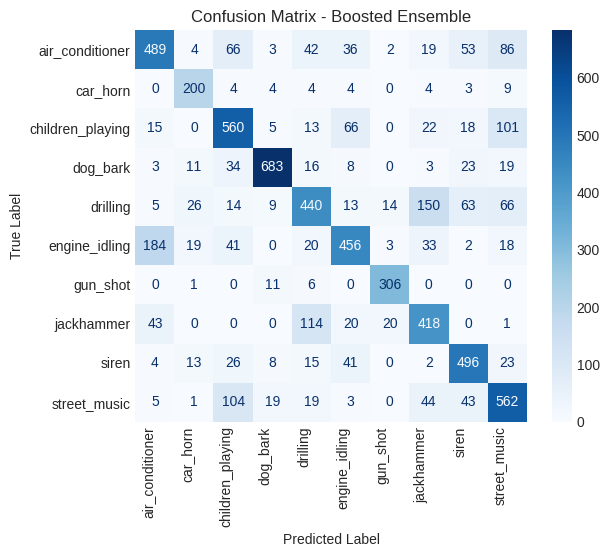

In [39]:
# Plot Confusion Matrix
cm = confusion_matrix(val_labels, boosted_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))

plt.figure(figsize=(8, 6))
ax = disp.plot(cmap="Blues", values_format="d").ax_
plt.title("Confusion Matrix - Boosted Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

plt.show()

# **Plot Losses And Acurracies for All Models Together**

In [22]:
all_model_data = [
    {
        "model_number": 1,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5387, "train_acc": 0.6410, "val_loss": 1.7140, "val_acc": 0.5807},
            {"epoch": 2, "train_loss": 1.2508, "train_acc": 0.8131, "val_loss": 1.6973, "val_acc": 0.6080},
            {"epoch": 3, "train_loss": 1.1648, "train_acc": 0.8572, "val_loss": 1.6860, "val_acc": 0.6364},
            {"epoch": 4, "train_loss": 1.1034, "train_acc": 0.8925, "val_loss": 1.7081, "val_acc": 0.6083},
            {"epoch": 5, "train_loss": 1.0795, "train_acc": 0.9034, "val_loss": 1.6643, "val_acc": 0.6411},
            {"epoch": 6, "train_loss": 1.0590, "train_acc": 0.9144, "val_loss": 1.7237, "val_acc": 0.6163},
            {"epoch": 7, "train_loss": 1.0327, "train_acc": 0.9267, "val_loss": 1.6534, "val_acc": 0.6407},
            {"epoch": 8, "train_loss": 0.9717, "train_acc": 0.9607, "val_loss": 1.7100, "val_acc": 0.6116},
            {"epoch": 9, "train_loss": 0.9572, "train_acc": 0.9692, "val_loss": 1.6525, "val_acc": 0.6369},
            {"epoch": 10, "train_loss": 0.9526, "train_acc": 0.9701, "val_loss": 1.6838, "val_acc": 0.6426},
            {"epoch": 11, "train_loss": 0.9490, "train_acc": 0.9714, "val_loss": 1.6773, "val_acc": 0.6401},
            {"epoch": 12, "train_loss": 0.9436, "train_acc": 0.9732, "val_loss": 1.7200, "val_acc": 0.6270},
            {"epoch": 13, "train_loss": 0.9386, "train_acc": 0.9754, "val_loss": 1.7192, "val_acc": 0.6262},
            {"epoch": 14, "train_loss": 0.9411, "train_acc": 0.9739, "val_loss": 1.6311, "val_acc": 0.6743},
            {"epoch": 15, "train_loss": 0.9107, "train_acc": 0.9886, "val_loss": 1.6750, "val_acc": 0.6477},
            {"epoch": 16, "train_loss": 0.9072, "train_acc": 0.9904, "val_loss": 1.6549, "val_acc": 0.6609},
            {"epoch": 17, "train_loss": 0.9065, "train_acc": 0.9903, "val_loss": 1.6746, "val_acc": 0.6481},
            {"epoch": 18, "train_loss": 0.9030, "train_acc": 0.9909, "val_loss": 1.6981, "val_acc": 0.6469},
            {"epoch": 19, "train_loss": 0.9030, "train_acc": 0.9910, "val_loss": 1.7254, "val_acc": 0.6271},
            {"epoch": 20, "train_loss": 0.9019, "train_acc": 0.9916, "val_loss": 1.7045, "val_acc": 0.6469},
            {"epoch": 21, "train_loss": 0.9047, "train_acc": 0.9897, "val_loss": 1.7131, "val_acc": 0.6346},
            {"epoch": 22, "train_loss": 0.8920, "train_acc": 0.9953, "val_loss": 1.6831, "val_acc": 0.6534},
            {"epoch": 23, "train_loss": 0.8882, "train_acc": 0.9967, "val_loss": 1.6742, "val_acc": 0.6493},
            {"epoch": 24, "train_loss": 0.8877, "train_acc": 0.9970, "val_loss": 1.6670, "val_acc": 0.6642},
            {"epoch": 25, "train_loss": 0.8869, "train_acc": 0.9972, "val_loss": 1.6731, "val_acc": 0.6680},
            {"epoch": 26, "train_loss": 0.8880, "train_acc": 0.9965, "val_loss": 1.6900, "val_acc": 0.6557},
            {"epoch": 27, "train_loss": 0.8864, "train_acc": 0.9971, "val_loss": 1.7066, "val_acc": 0.6405},
            {"epoch": 28, "train_loss": 0.8869, "train_acc": 0.9971, "val_loss": 1.7009, "val_acc": 0.6512},
            {"epoch": 29, "train_loss": 0.8820, "train_acc": 0.9987, "val_loss": 1.6702, "val_acc": 0.6624},
            {"epoch": 30, "train_loss": 0.8814, "train_acc": 0.9985, "val_loss": 1.7262, "val_acc": 0.6381}
        ]
    },
    {
        "model_number": 2,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5112, "train_acc": 0.6587, "val_loss": 1.7711, "val_acc": 0.5560},
            {"epoch": 2, "train_loss": 1.2447, "train_acc": 0.8177, "val_loss": 1.7606, "val_acc": 0.5823},
            {"epoch": 3, "train_loss": 1.1575, "train_acc": 0.8643, "val_loss": 1.7778, "val_acc": 0.5987},
            {"epoch": 4, "train_loss": 1.1135, "train_acc": 0.8870, "val_loss": 1.8114, "val_acc": 0.5696},
            {"epoch": 5, "train_loss": 1.0735, "train_acc": 0.9093, "val_loss": 1.7916, "val_acc": 0.5915},
            {"epoch": 6, "train_loss": 1.0628, "train_acc": 0.9133, "val_loss": 1.7150, "val_acc": 0.6227},
            {"epoch": 7, "train_loss": 1.0441, "train_acc": 0.9227, "val_loss": 1.7550, "val_acc": 0.5979},
            {"epoch": 8, "train_loss": 0.9879, "train_acc": 0.9549, "val_loss": 1.7529, "val_acc": 0.6267},
            {"epoch": 9, "train_loss": 0.9734, "train_acc": 0.9642, "val_loss": 1.7907, "val_acc": 0.6007},
            {"epoch": 10, "train_loss": 0.9689, "train_acc": 0.9657, "val_loss": 1.7373, "val_acc": 0.6174},
            {"epoch": 11, "train_loss": 0.9683, "train_acc": 0.9663, "val_loss": 1.7824, "val_acc": 0.6136},
            {"epoch": 12, "train_loss": 0.9628, "train_acc": 0.9699, "val_loss": 1.7725, "val_acc": 0.6171},
            {"epoch": 13, "train_loss": 0.9627, "train_acc": 0.9689, "val_loss": 1.7630, "val_acc": 0.6183},
            {"epoch": 14, "train_loss": 0.9590, "train_acc": 0.9700, "val_loss": 1.7400, "val_acc": 0.6209},
            {"epoch": 15, "train_loss": 0.9334, "train_acc": 0.9844, "val_loss": 1.7346, "val_acc": 0.6382},
            {"epoch": 16, "train_loss": 0.9278, "train_acc": 0.9866, "val_loss": 1.7696, "val_acc": 0.6236},
            {"epoch": 17, "train_loss": 0.9266, "train_acc": 0.9871, "val_loss": 1.7400, "val_acc": 0.6334},
            {"epoch": 18, "train_loss": 0.9245, "train_acc": 0.9882, "val_loss": 1.7257, "val_acc": 0.6381},
            {"epoch": 19, "train_loss": 0.9257, "train_acc": 0.9878, "val_loss": 1.7763, "val_acc": 0.6119},
            {"epoch": 20, "train_loss": 0.9245, "train_acc": 0.9885, "val_loss": 1.7877, "val_acc": 0.6174},
            {"epoch": 21, "train_loss": 0.9221, "train_acc": 0.9902, "val_loss": 1.7575, "val_acc": 0.6280},
            {"epoch": 22, "train_loss": 0.9119, "train_acc": 0.9936, "val_loss": 1.7342, "val_acc": 0.6340},
            {"epoch": 23, "train_loss": 0.9087, "train_acc": 0.9948, "val_loss": 1.7402, "val_acc": 0.6381},
            {"epoch": 24, "train_loss": 0.9087, "train_acc": 0.9948, "val_loss": 1.7582, "val_acc": 0.6373},
            {"epoch": 25, "train_loss": 0.9078, "train_acc": 0.9958, "val_loss": 1.7490, "val_acc": 0.6376},
            {"epoch": 26, "train_loss": 0.9089, "train_acc": 0.9939, "val_loss": 1.7330, "val_acc": 0.6420},
            {"epoch": 27, "train_loss": 0.9070, "train_acc": 0.9948, "val_loss": 1.7482, "val_acc": 0.6338},
            {"epoch": 28, "train_loss": 0.9068, "train_acc": 0.9953, "val_loss": 1.7287, "val_acc": 0.6396},
            {"epoch": 29, "train_loss": 0.9017, "train_acc": 0.9963, "val_loss": 1.7339, "val_acc": 0.6401},
            {"epoch": 30, "train_loss": 0.9009, "train_acc": 0.9968, "val_loss": 1.7199, "val_acc": 0.6429}
        ]
    },
    {
        "model_number": 3,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5166, "train_acc": 0.6536, "val_loss": 1.7596, "val_acc": 0.5684},
            {"epoch": 2, "train_loss": 1.2270, "train_acc": 0.8236, "val_loss": 1.7959, "val_acc": 0.5636},
            {"epoch": 3, "train_loss": 1.1396, "train_acc": 0.8714, "val_loss": 1.7684, "val_acc": 0.6106},
            {"epoch": 4, "train_loss": 1.0915, "train_acc": 0.8968, "val_loss": 1.6962, "val_acc": 0.6098},
            {"epoch": 5, "train_loss": 1.0668, "train_acc": 0.9080, "val_loss": 1.7660, "val_acc": 0.5953},
            {"epoch": 6, "train_loss": 1.0378, "train_acc": 0.9256, "val_loss": 1.7123, "val_acc": 0.6220},
            {"epoch": 7, "train_loss": 1.0246, "train_acc": 0.9318, "val_loss": 1.7282, "val_acc": 0.6306},
            {"epoch": 8, "train_loss": 0.9654, "train_acc": 0.9638, "val_loss": 1.7423, "val_acc": 0.6020},
            {"epoch": 9, "train_loss": 0.9541, "train_acc": 0.9679, "val_loss": 1.7270, "val_acc": 0.6253},
            {"epoch": 10, "train_loss": 0.9470, "train_acc": 0.9713, "val_loss": 1.7156, "val_acc": 0.6197},
            {"epoch": 11, "train_loss": 0.9490, "train_acc": 0.9712, "val_loss": 1.7182, "val_acc": 0.6264},
            {"epoch": 12, "train_loss": 0.9439, "train_acc": 0.9723, "val_loss": 1.7227, "val_acc": 0.6250},
            {"epoch": 13, "train_loss": 0.9349, "train_acc": 0.9761, "val_loss": 1.7101, "val_acc": 0.6332},
            {"epoch": 14, "train_loss": 0.9354, "train_acc": 0.9756, "val_loss": 1.7137, "val_acc": 0.6315},
            {"epoch": 15, "train_loss": 0.9082, "train_acc": 0.9890, "val_loss": 1.7058, "val_acc": 0.6385},
            {"epoch": 16, "train_loss": 0.9002, "train_acc": 0.9931, "val_loss": 1.7529, "val_acc": 0.6168},
            {"epoch": 17, "train_loss": 0.9015, "train_acc": 0.9912, "val_loss": 1.7401, "val_acc": 0.6171},
            {"epoch": 18, "train_loss": 0.8980, "train_acc": 0.9930, "val_loss": 1.6772, "val_acc": 0.6525},
            {"epoch": 19, "train_loss": 0.9025, "train_acc": 0.9908, "val_loss": 1.7427, "val_acc": 0.6303},
            {"epoch": 20, "train_loss": 0.9004, "train_acc": 0.9915, "val_loss": 1.7489, "val_acc": 0.6209},
            {"epoch": 21, "train_loss": 0.9021, "train_acc": 0.9905, "val_loss": 1.7716, "val_acc": 0.6210},
            {"epoch": 22, "train_loss": 0.8887, "train_acc": 0.9963, "val_loss": 1.7112, "val_acc": 0.6402},
            {"epoch": 23, "train_loss": 0.8853, "train_acc": 0.9971, "val_loss": 1.7044, "val_acc": 0.6461},
            {"epoch": 24, "train_loss": 0.8858, "train_acc": 0.9972, "val_loss": 1.7302, "val_acc": 0.6385},
            {"epoch": 25, "train_loss": 0.8847, "train_acc": 0.9975, "val_loss": 1.6992, "val_acc": 0.6557},
            {"epoch": 26, "train_loss": 0.8850, "train_acc": 0.9971, "val_loss": 1.7134, "val_acc": 0.6509},
            {"epoch": 27, "train_loss": 0.8858, "train_acc": 0.9967, "val_loss": 1.7436, "val_acc": 0.6320},
            {"epoch": 28, "train_loss": 0.8865, "train_acc": 0.9966, "val_loss": 1.7235, "val_acc": 0.6417},
            {"epoch": 29, "train_loss": 0.8805, "train_acc": 0.9985, "val_loss": 1.7321, "val_acc": 0.6352},
            {"epoch": 30, "train_loss": 0.8796, "train_acc": 0.9988, "val_loss": 1.7316, "val_acc": 0.6419}
        ]
    },
    {
        "model_number": 4,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5207, "train_acc": 0.6517, "val_loss": 1.7359, "val_acc": 0.5917},
            {"epoch": 2, "train_loss": 1.2456, "train_acc": 0.8148, "val_loss": 1.7502, "val_acc": 0.5864},
            {"epoch": 3, "train_loss": 1.1612, "train_acc": 0.8633, "val_loss": 1.7555, "val_acc": 0.5824},
            {"epoch": 4, "train_loss": 1.1104, "train_acc": 0.8882, "val_loss": 1.7441, "val_acc": 0.5899},
            {"epoch": 5, "train_loss": 1.0745, "train_acc": 0.9098, "val_loss": 1.7331, "val_acc": 0.6230},
            {"epoch": 6, "train_loss": 1.0488, "train_acc": 0.9250, "val_loss": 1.7407, "val_acc": 0.6023},
            {"epoch": 7, "train_loss": 1.0278, "train_acc": 0.9352, "val_loss": 1.7343, "val_acc": 0.5964},
            {"epoch": 8, "train_loss": 0.9801, "train_acc": 0.9621, "val_loss": 1.7445, "val_acc": 0.6198},
            {"epoch": 9, "train_loss": 0.9655, "train_acc": 0.9703, "val_loss": 1.7484, "val_acc": 0.6182},
            {"epoch": 10, "train_loss": 0.9622, "train_acc": 0.9713, "val_loss": 1.8220, "val_acc": 0.5914},
            {"epoch": 11, "train_loss": 0.9609, "train_acc": 0.9701, "val_loss": 1.7407, "val_acc": 0.6118},
            {"epoch": 12, "train_loss": 0.9611, "train_acc": 0.9704, "val_loss": 1.7159, "val_acc": 0.6159},
            {"epoch": 13, "train_loss": 0.9543, "train_acc": 0.9735, "val_loss": 1.7800, "val_acc": 0.6043},
            {"epoch": 14, "train_loss": 0.9543, "train_acc": 0.9746, "val_loss": 1.7801, "val_acc": 0.6087},
            {"epoch": 15, "train_loss": 0.9267, "train_acc": 0.9873, "val_loss": 1.7418, "val_acc": 0.6206},
            {"epoch": 16, "train_loss": 0.9213, "train_acc": 0.9893, "val_loss": 1.7856, "val_acc": 0.6183},
            {"epoch": 17, "train_loss": 0.9191, "train_acc": 0.9908, "val_loss": 1.7515, "val_acc": 0.6139},
            {"epoch": 18, "train_loss": 0.9206, "train_acc": 0.9903, "val_loss": 1.6900, "val_acc": 0.6353},
            {"epoch": 19, "train_loss": 0.9189, "train_acc": 0.9910, "val_loss": 1.7870, "val_acc": 0.6195},
            {"epoch": 20, "train_loss": 0.9193, "train_acc": 0.9907, "val_loss": 1.8237, "val_acc": 0.6060},
            {"epoch": 21, "train_loss": 0.9182, "train_acc": 0.9906, "val_loss": 1.7685, "val_acc": 0.6183},
            {"epoch": 22, "train_loss": 0.9073, "train_acc": 0.9950, "val_loss": 1.7510, "val_acc": 0.6204},
            {"epoch": 23, "train_loss": 0.9032, "train_acc": 0.9969, "val_loss": 1.7690, "val_acc": 0.6159},
            {"epoch": 24, "train_loss": 0.9045, "train_acc": 0.9959, "val_loss": 1.7616, "val_acc": 0.6175},
            {"epoch": 25, "train_loss": 0.9041, "train_acc": 0.9963, "val_loss": 1.7535, "val_acc": 0.6241},
            {"epoch": 26, "train_loss": 0.9032, "train_acc": 0.9966, "val_loss": 1.7269, "val_acc": 0.6262},
            {"epoch": 27, "train_loss": 0.9027, "train_acc": 0.9966, "val_loss": 1.7661, "val_acc": 0.6227},
            {"epoch": 28, "train_loss": 0.9031, "train_acc": 0.9969, "val_loss": 1.7879, "val_acc": 0.6119},
            {"epoch": 29, "train_loss": 0.8980, "train_acc": 0.9977, "val_loss": 1.7501, "val_acc": 0.6232},
            {"epoch": 30, "train_loss": 0.8969, "train_acc": 0.9979, "val_loss": 1.7607, "val_acc": 0.6235}
        ]
    },
    {
        "model_number": 5,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5580, "train_acc": 0.6272, "val_loss": 1.7431, "val_acc": 0.5741},
            {"epoch": 2, "train_loss": 1.2870, "train_acc": 0.7913, "val_loss": 1.7857, "val_acc": 0.5627},
            {"epoch": 3, "train_loss": 1.1940, "train_acc": 0.8420, "val_loss": 1.8296, "val_acc": 0.5677},
            {"epoch": 4, "train_loss": 1.1518, "train_acc": 0.8644, "val_loss": 1.7804, "val_acc": 0.5824},
            {"epoch": 5, "train_loss": 1.1152, "train_acc": 0.8858, "val_loss": 1.7840, "val_acc": 0.5940},
            {"epoch": 6, "train_loss": 1.1018, "train_acc": 0.8924, "val_loss": 1.8283, "val_acc": 0.5873},
            {"epoch": 7, "train_loss": 1.0861, "train_acc": 0.8996, "val_loss": 1.7333, "val_acc": 0.6233},
            {"epoch": 8, "train_loss": 1.0295, "train_acc": 0.9338, "val_loss": 1.7561, "val_acc": 0.6233},
            {"epoch": 9, "train_loss": 1.0184, "train_acc": 0.9372, "val_loss": 1.7210, "val_acc": 0.6233},
            {"epoch": 10, "train_loss": 1.0120, "train_acc": 0.9426, "val_loss": 1.7523, "val_acc": 0.6207},
            {"epoch": 11, "train_loss": 1.0100, "train_acc": 0.9434, "val_loss": 1.7642, "val_acc": 0.6151},
            {"epoch": 12, "train_loss": 1.0036, "train_acc": 0.9463, "val_loss": 1.7873, "val_acc": 0.6125},
            {"epoch": 13, "train_loss": 0.9970, "train_acc": 0.9493, "val_loss": 1.7383, "val_acc": 0.6279},
            {"epoch": 14, "train_loss": 0.9940, "train_acc": 0.9508, "val_loss": 1.7637, "val_acc": 0.6264},
            {"epoch": 15, "train_loss": 0.9714, "train_acc": 0.9658, "val_loss": 1.7912, "val_acc": 0.6172},
            {"epoch": 16, "train_loss": 0.9656, "train_acc": 0.9674, "val_loss": 1.7931, "val_acc": 0.6177},
            {"epoch": 17, "train_loss": 0.9632, "train_acc": 0.9678, "val_loss": 1.7949, "val_acc": 0.6186},
            {"epoch": 18, "train_loss": 0.9607, "train_acc": 0.9686, "val_loss": 1.7999, "val_acc": 0.6144},
            {"epoch": 19, "train_loss": 0.9610, "train_acc": 0.9692, "val_loss": 1.8036, "val_acc": 0.6185},
            {"epoch": 20, "train_loss": 0.9587, "train_acc": 0.9701, "val_loss": 1.8163, "val_acc": 0.6080},
            {"epoch": 21, "train_loss": 0.9579, "train_acc": 0.9703, "val_loss": 1.7870, "val_acc": 0.6267},
            {"epoch": 22, "train_loss": 0.9446, "train_acc": 0.9775, "val_loss": 1.8022, "val_acc": 0.6212},
            {"epoch": 23, "train_loss": 0.9427, "train_acc": 0.9788, "val_loss": 1.8223, "val_acc": 0.6244},
            {"epoch": 24, "train_loss": 0.9414, "train_acc": 0.9784, "val_loss": 1.8047, "val_acc": 0.6229},
            {"epoch": 25, "train_loss": 0.9402, "train_acc": 0.9786, "val_loss": 1.8244, "val_acc": 0.6220},
            {"epoch": 26, "train_loss": 0.9392, "train_acc": 0.9799, "val_loss": 1.8368, "val_acc": 0.6174},
            {"epoch": 27, "train_loss": 0.9385, "train_acc": 0.9795, "val_loss": 1.8150, "val_acc": 0.6265},
            {"epoch": 28, "train_loss": 0.9373, "train_acc": 0.9804, "val_loss": 1.8069, "val_acc": 0.6171},
            {"epoch": 29, "train_loss": 0.9310, "train_acc": 0.9841, "val_loss": 1.8106, "val_acc": 0.6259},
            {"epoch": 30, "train_loss": 0.9307, "train_acc": 0.9838, "val_loss": 1.8074, "val_acc": 0.6217}
        ]
    },
    {
        "model_number": 6,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5715, "train_acc": 0.6233, "val_loss": 1.7145, "val_acc": 0.5763},
            {"epoch": 2, "train_loss": 1.2934, "train_acc": 0.7886, "val_loss": 1.8900, "val_acc": 0.5655},
            {"epoch": 3, "train_loss": 1.2058, "train_acc": 0.8375, "val_loss": 1.7575, "val_acc": 0.6064},
            {"epoch": 4, "train_loss": 1.1582, "train_acc": 0.8646, "val_loss": 1.7410, "val_acc": 0.6017},
            {"epoch": 5, "train_loss": 1.1259, "train_acc": 0.8853, "val_loss": 1.7289, "val_acc": 0.6204},
            {"epoch": 6, "train_loss": 1.1069, "train_acc": 0.8933, "val_loss": 1.7086, "val_acc": 0.6428},
            {"epoch": 7, "train_loss": 1.0893, "train_acc": 0.9057, "val_loss": 1.7286, "val_acc": 0.6328},
            {"epoch": 8, "train_loss": 1.0493, "train_acc": 0.9290, "val_loss": 1.7014, "val_acc": 0.6390},
            {"epoch": 9, "train_loss": 1.0369, "train_acc": 0.9355, "val_loss": 1.7270, "val_acc": 0.6302},
            {"epoch": 10, "train_loss": 1.0305, "train_acc": 0.9412, "val_loss": 1.7061, "val_acc": 0.6326},
            {"epoch": 11, "train_loss": 1.0277, "train_acc": 0.9392, "val_loss": 1.6717, "val_acc": 0.6525},
            {"epoch": 12, "train_loss": 1.0224, "train_acc": 0.9437, "val_loss": 1.6981, "val_acc": 0.6425},
            {"epoch": 13, "train_loss": 1.0202, "train_acc": 0.9443, "val_loss": 1.7357, "val_acc": 0.6279},
            {"epoch": 14, "train_loss": 1.0148, "train_acc": 0.9472, "val_loss": 1.7475, "val_acc": 0.6318},
            {"epoch": 15, "train_loss": 0.9955, "train_acc": 0.9598, "val_loss": 1.7313, "val_acc": 0.6328},
            {"epoch": 16, "train_loss": 0.9900, "train_acc": 0.9630, "val_loss": 1.7086, "val_acc": 0.6375},
            {"epoch": 17, "train_loss": 0.9892, "train_acc": 0.9632, "val_loss": 1.7077, "val_acc": 0.6481},
            {"epoch": 18, "train_loss": 0.9877, "train_acc": 0.9637, "val_loss": 1.6861, "val_acc": 0.6516},
            {"epoch": 19, "train_loss": 0.9861, "train_acc": 0.9638, "val_loss": 1.7464, "val_acc": 0.6218},
            {"epoch": 20, "train_loss": 0.9849, "train_acc": 0.9652, "val_loss": 1.7123, "val_acc": 0.6372},
            {"epoch": 21, "train_loss": 0.9816, "train_acc": 0.9672, "val_loss": 1.6981, "val_acc": 0.6443},
            {"epoch": 22, "train_loss": 0.9722, "train_acc": 0.9748, "val_loss": 1.7010, "val_acc": 0.6398},
            {"epoch": 23, "train_loss": 0.9704, "train_acc": 0.9736, "val_loss": 1.7052, "val_acc": 0.6432},
            {"epoch": 24, "train_loss": 0.9697, "train_acc": 0.9737, "val_loss": 1.7137, "val_acc": 0.6335},
            {"epoch": 25, "train_loss": 0.9674, "train_acc": 0.9752, "val_loss": 1.7031, "val_acc": 0.6355},
            {"epoch": 26, "train_loss": 0.9686, "train_acc": 0.9740, "val_loss": 1.7089, "val_acc": 0.6408},
            {"epoch": 27, "train_loss": 0.9678, "train_acc": 0.9754, "val_loss": 1.7148, "val_acc": 0.6369},
            {"epoch": 28, "train_loss": 0.9665, "train_acc": 0.9756, "val_loss": 1.6855, "val_acc": 0.6515},
            {"epoch": 29, "train_loss": 0.9617, "train_acc": 0.9787, "val_loss": 1.7035, "val_acc": 0.6390},
            {"epoch": 30, "train_loss": 0.9611, "train_acc": 0.9788, "val_loss": 1.7099, "val_acc": 0.6419}
        ]
    },
    {
        "model_number": 7,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5009, "train_acc": 0.6618, "val_loss": 1.7001, "val_acc": 0.5773},
            {"epoch": 2, "train_loss": 1.2102, "train_acc": 0.8351, "val_loss": 1.7269, "val_acc": 0.5914},
            {"epoch": 3, "train_loss": 1.1309, "train_acc": 0.8743, "val_loss": 1.7135, "val_acc": 0.6052},
            {"epoch": 4, "train_loss": 1.0764, "train_acc": 0.9040, "val_loss": 1.7098, "val_acc": 0.6204},
            {"epoch": 5, "train_loss": 1.0436, "train_acc": 0.9191, "val_loss": 1.7305, "val_acc": 0.6169},
            {"epoch": 6, "train_loss": 1.0228, "train_acc": 0.9309, "val_loss": 1.7094, "val_acc": 0.6214},
            {"epoch": 7, "train_loss": 1.0061, "train_acc": 0.9380, "val_loss": 1.7257, "val_acc": 0.6166},
            {"epoch": 8, "train_loss": 0.9492, "train_acc": 0.9695, "val_loss": 1.7016, "val_acc": 0.6442},
            {"epoch": 9, "train_loss": 0.9323, "train_acc": 0.9788, "val_loss": 1.6779, "val_acc": 0.6399},
            {"epoch": 10, "train_loss": 0.9357, "train_acc": 0.9752, "val_loss": 1.7139, "val_acc": 0.6499},
            {"epoch": 11, "train_loss": 0.9314, "train_acc": 0.9774, "val_loss": 1.7287, "val_acc": 0.6489},
            {"epoch": 12, "train_loss": 0.9281, "train_acc": 0.9783, "val_loss": 1.7094, "val_acc": 0.6436},
            {"epoch": 13, "train_loss": 0.9280, "train_acc": 0.9787, "val_loss": 1.7292, "val_acc": 0.6318},
            {"epoch": 14, "train_loss": 0.9329, "train_acc": 0.9750, "val_loss": 1.7165, "val_acc": 0.6407},
            {"epoch": 15, "train_loss": 0.8999, "train_acc": 0.9918, "val_loss": 1.6868, "val_acc": 0.6559},
            {"epoch": 16, "train_loss": 0.8936, "train_acc": 0.9936, "val_loss": 1.6632, "val_acc": 0.6665},
            {"epoch": 17, "train_loss": 0.8931, "train_acc": 0.9943, "val_loss": 1.7050, "val_acc": 0.6475},
            {"epoch": 18, "train_loss": 0.8928, "train_acc": 0.9939, "val_loss": 1.7091, "val_acc": 0.6560},
            {"epoch": 19, "train_loss": 0.8949, "train_acc": 0.9925, "val_loss": 1.7326, "val_acc": 0.6434},
            {"epoch": 20, "train_loss": 0.8949, "train_acc": 0.9927, "val_loss": 1.7272, "val_acc": 0.6398},
            {"epoch": 21, "train_loss": 0.8946, "train_acc": 0.9925, "val_loss": 1.7108, "val_acc": 0.6507},
            {"epoch": 22, "train_loss": 0.8845, "train_acc": 0.9969, "val_loss": 1.6926, "val_acc": 0.6620},
            {"epoch": 23, "train_loss": 0.8814, "train_acc": 0.9978, "val_loss": 1.7018, "val_acc": 0.6662},
            {"epoch": 24, "train_loss": 0.8801, "train_acc": 0.9983, "val_loss": 1.7120, "val_acc": 0.6501},
            {"epoch": 25, "train_loss": 0.8804, "train_acc": 0.9983, "val_loss": 1.6895, "val_acc": 0.6662},
            {"epoch": 26, "train_loss": 0.8833, "train_acc": 0.9968, "val_loss": 1.6887, "val_acc": 0.6673},
            {"epoch": 27, "train_loss": 0.8796, "train_acc": 0.9988, "val_loss": 1.7221, "val_acc": 0.6537},
            {"epoch": 28, "train_loss": 0.8822, "train_acc": 0.9969, "val_loss": 1.6966, "val_acc": 0.6586},
            {"epoch": 29, "train_loss": 0.8777, "train_acc": 0.9983, "val_loss": 1.7137, "val_acc": 0.6604},
            {"epoch": 30, "train_loss": 0.8759, "train_acc": 0.9993, "val_loss": 1.7141, "val_acc": 0.6480}
        ]
    },
    {
        "model_number": 8,
        "epochs": [
            {"epoch": 1, "train_loss": 1.4999, "train_acc": 0.6639, "val_loss": 1.6650, "val_acc": 0.6145},
            {"epoch": 2, "train_loss": 1.2143, "train_acc": 0.8326, "val_loss": 1.7427, "val_acc": 0.6074},
            {"epoch": 3, "train_loss": 1.1229, "train_acc": 0.8817, "val_loss": 1.7368, "val_acc": 0.5970},
            {"epoch": 4, "train_loss": 1.0787, "train_acc": 0.9063, "val_loss": 1.7228, "val_acc": 0.6151},
            {"epoch": 5, "train_loss": 1.0453, "train_acc": 0.9244, "val_loss": 1.7848, "val_acc": 0.5855},
            {"epoch": 6, "train_loss": 1.0245, "train_acc": 0.9336, "val_loss": 1.7658, "val_acc": 0.6090},
            {"epoch": 7, "train_loss": 1.0118, "train_acc": 0.9403, "val_loss": 1.7347, "val_acc": 0.6101},
            {"epoch": 8, "train_loss": 0.9615, "train_acc": 0.9694, "val_loss": 1.6780, "val_acc": 0.6402},
            {"epoch": 9, "train_loss": 0.9495, "train_acc": 0.9747, "val_loss": 1.6923, "val_acc": 0.6393},
            {"epoch": 10, "train_loss": 0.9485, "train_acc": 0.9757, "val_loss": 1.7498, "val_acc": 0.6119},
            {"epoch": 11, "train_loss": 0.9437, "train_acc": 0.9780, "val_loss": 1.7496, "val_acc": 0.6169},
            {"epoch": 12, "train_loss": 0.9426, "train_acc": 0.9785, "val_loss": 1.7324, "val_acc": 0.6150},
            {"epoch": 13, "train_loss": 0.9440, "train_acc": 0.9755, "val_loss": 1.7116, "val_acc": 0.6344},
            {"epoch": 14, "train_loss": 0.9420, "train_acc": 0.9776, "val_loss": 1.7123, "val_acc": 0.6309},
            {"epoch": 15, "train_loss": 0.9170, "train_acc": 0.9901, "val_loss": 1.7299, "val_acc": 0.6265},
            {"epoch": 16, "train_loss": 0.9126, "train_acc": 0.9916, "val_loss": 1.7291, "val_acc": 0.6329},
            {"epoch": 17, "train_loss": 0.9120, "train_acc": 0.9925, "val_loss": 1.7223, "val_acc": 0.6241},
            {"epoch": 18, "train_loss": 0.9101, "train_acc": 0.9928, "val_loss": 1.7525, "val_acc": 0.6226},
            {"epoch": 19, "train_loss": 0.9090, "train_acc": 0.9927, "val_loss": 1.7451, "val_acc": 0.6223},
            {"epoch": 20, "train_loss": 0.9092, "train_acc": 0.9929, "val_loss": 1.7318, "val_acc": 0.6318},
            {"epoch": 21, "train_loss": 0.9131, "train_acc": 0.9904, "val_loss": 1.7484, "val_acc": 0.6247},
            {"epoch": 22, "train_loss": 0.8993, "train_acc": 0.9973, "val_loss": 1.7038, "val_acc": 0.6355},
            {"epoch": 23, "train_loss": 0.8969, "train_acc": 0.9972, "val_loss": 1.7352, "val_acc": 0.6267},
            {"epoch": 24, "train_loss": 0.8961, "train_acc": 0.9977, "val_loss": 1.7277, "val_acc": 0.6239},
            {"epoch": 25, "train_loss": 0.8963, "train_acc": 0.9976, "val_loss": 1.7456, "val_acc": 0.6200},
            {"epoch": 26, "train_loss": 0.8963, "train_acc": 0.9973, "val_loss": 1.7580, "val_acc": 0.6168},
            {"epoch": 27, "train_loss": 0.8962, "train_acc": 0.9976, "val_loss": 1.7229, "val_acc": 0.6318},
            {"epoch": 28, "train_loss": 0.8963, "train_acc": 0.9970, "val_loss": 1.7523, "val_acc": 0.6163},
            {"epoch": 29, "train_loss": 0.8920, "train_acc": 0.9985, "val_loss": 1.7277, "val_acc": 0.6262},
            {"epoch": 30, "train_loss": 0.8906, "train_acc": 0.9989, "val_loss": 1.7347, "val_acc": 0.6226}
        ]
    },
    {
        "model_number": 9,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5610, "train_acc": 0.6272, "val_loss": 1.7584, "val_acc": 0.5546},
            {"epoch": 2, "train_loss": 1.2672, "train_acc": 0.8022, "val_loss": 1.7831, "val_acc": 0.5692},
            {"epoch": 3, "train_loss": 1.1863, "train_acc": 0.8462, "val_loss": 1.7647, "val_acc": 0.5871},
            {"epoch": 4, "train_loss": 1.1345, "train_acc": 0.8760, "val_loss": 1.7694, "val_acc": 0.5658},
            {"epoch": 5, "train_loss": 1.1058, "train_acc": 0.8920, "val_loss": 1.7100, "val_acc": 0.6037},
            {"epoch": 6, "train_loss": 1.0854, "train_acc": 0.9017, "val_loss": 1.7397, "val_acc": 0.5934},
            {"epoch": 7, "train_loss": 1.0621, "train_acc": 0.9151, "val_loss": 1.6957, "val_acc": 0.6338},
            {"epoch": 8, "train_loss": 1.0156, "train_acc": 0.9396, "val_loss": 1.6783, "val_acc": 0.6325},
            {"epoch": 9, "train_loss": 1.0050, "train_acc": 0.9462, "val_loss": 1.7117, "val_acc": 0.6165},
            {"epoch": 10, "train_loss": 0.9989, "train_acc": 0.9503, "val_loss": 1.7040, "val_acc": 0.6255},
            {"epoch": 11, "train_loss": 0.9947, "train_acc": 0.9510, "val_loss": 1.6855, "val_acc": 0.6451},
            {"epoch": 12, "train_loss": 0.9945, "train_acc": 0.9508, "val_loss": 1.6929, "val_acc": 0.6277},
            {"epoch": 13, "train_loss": 0.9868, "train_acc": 0.9558, "val_loss": 1.7079, "val_acc": 0.6320},
            {"epoch": 14, "train_loss": 0.9856, "train_acc": 0.9552, "val_loss": 1.7433, "val_acc": 0.6069},
            {"epoch": 15, "train_loss": 0.9635, "train_acc": 0.9673, "val_loss": 1.7145, "val_acc": 0.6172},
            {"epoch": 16, "train_loss": 0.9559, "train_acc": 0.9706, "val_loss": 1.6959, "val_acc": 0.6402},
            {"epoch": 17, "train_loss": 0.9541, "train_acc": 0.9707, "val_loss": 1.7054, "val_acc": 0.6358},
            {"epoch": 18, "train_loss": 0.9516, "train_acc": 0.9728, "val_loss": 1.7008, "val_acc": 0.6387},
            {"epoch": 19, "train_loss": 0.9489, "train_acc": 0.9749, "val_loss": 1.7813, "val_acc": 0.6153},
            {"epoch": 20, "train_loss": 0.9504, "train_acc": 0.9732, "val_loss": 1.7644, "val_acc": 0.6154},
            {"epoch": 21, "train_loss": 0.9462, "train_acc": 0.9743, "val_loss": 1.7359, "val_acc": 0.6334},
            {"epoch": 22, "train_loss": 0.9355, "train_acc": 0.9816, "val_loss": 1.7366, "val_acc": 0.6276},
            {"epoch": 23, "train_loss": 0.9340, "train_acc": 0.9824, "val_loss": 1.7273, "val_acc": 0.6309},
            {"epoch": 24, "train_loss": 0.9331, "train_acc": 0.9835, "val_loss": 1.7036, "val_acc": 0.6516},
            {"epoch": 25, "train_loss": 0.9309, "train_acc": 0.9830, "val_loss": 1.7078, "val_acc": 0.6396},
            {"epoch": 26, "train_loss": 0.9313, "train_acc": 0.9828, "val_loss": 1.7208, "val_acc": 0.6372},
            {"epoch": 27, "train_loss": 0.9309, "train_acc": 0.9825, "val_loss": 1.7376, "val_acc": 0.6318},
            {"epoch": 28, "train_loss": 0.9292, "train_acc": 0.9830, "val_loss": 1.7461, "val_acc": 0.6258},
            {"epoch": 29, "train_loss": 0.9237, "train_acc": 0.9864, "val_loss": 1.7339, "val_acc": 0.6344},
            {"epoch": 30, "train_loss": 0.9231, "train_acc": 0.9871, "val_loss": 1.7194, "val_acc": 0.6449}
        ]
    },
    {
        "model_number": 10,
        "epochs": [
            {"epoch": 1, "train_loss": 1.5725, "train_acc": 0.6235, "val_loss": 1.7417, "val_acc": 0.5776},
            {"epoch": 2, "train_loss": 1.2845, "train_acc": 0.7943, "val_loss": 1.7320, "val_acc": 0.6113},
            {"epoch": 3, "train_loss": 1.1994, "train_acc": 0.8400, "val_loss": 1.7081, "val_acc": 0.6124},
            {"epoch": 4, "train_loss": 1.1546, "train_acc": 0.8655, "val_loss": 1.6565, "val_acc": 0.6355},
            {"epoch": 5, "train_loss": 1.1226, "train_acc": 0.8850, "val_loss": 1.7158, "val_acc": 0.6066},
            {"epoch": 6, "train_loss": 1.1039, "train_acc": 0.8948, "val_loss": 1.6762, "val_acc": 0.6300},
            {"epoch": 7, "train_loss": 1.0885, "train_acc": 0.9028, "val_loss": 1.7221, "val_acc": 0.6101},
            {"epoch": 8, "train_loss": 1.0439, "train_acc": 0.9278, "val_loss": 1.7084, "val_acc": 0.6218},
            {"epoch": 9, "train_loss": 1.0341, "train_acc": 0.9355, "val_loss": 1.6993, "val_acc": 0.6314},
            {"epoch": 10, "train_loss": 1.0281, "train_acc": 0.9392, "val_loss": 1.7341, "val_acc": 0.6086},
            {"epoch": 11, "train_loss": 1.0240, "train_acc": 0.9391, "val_loss": 1.7220, "val_acc": 0.6242},
            {"epoch": 12, "train_loss": 1.0211, "train_acc": 0.9411, "val_loss": 1.6832, "val_acc": 0.6361},
            {"epoch": 13, "train_loss": 1.0171, "train_acc": 0.9460, "val_loss": 1.7105, "val_acc": 0.6337},
            {"epoch": 14, "train_loss": 1.0143, "train_acc": 0.9454, "val_loss": 1.7326, "val_acc": 0.6233},
            {"epoch": 15, "train_loss": 0.9933, "train_acc": 0.9585, "val_loss": 1.7194, "val_acc": 0.6268},
            {"epoch": 16, "train_loss": 0.9891, "train_acc": 0.9613, "val_loss": 1.7258, "val_acc": 0.6273},
            {"epoch": 17, "train_loss": 0.9867, "train_acc": 0.9625, "val_loss": 1.7416, "val_acc": 0.6223},
            {"epoch": 18, "train_loss": 0.9843, "train_acc": 0.9633, "val_loss": 1.7143, "val_acc": 0.6390},
            {"epoch": 19, "train_loss": 0.9849, "train_acc": 0.9621, "val_loss": 1.7251, "val_acc": 0.6331},
            {"epoch": 20, "train_loss": 0.9826, "train_acc": 0.9641, "val_loss": 1.7410, "val_acc": 0.6288},
            {"epoch": 21, "train_loss": 0.9791, "train_acc": 0.9672, "val_loss": 1.7325, "val_acc": 0.6280},
            {"epoch": 22, "train_loss": 0.9706, "train_acc": 0.9708, "val_loss": 1.7229, "val_acc": 0.6356},
            {"epoch": 23, "train_loss": 0.9695, "train_acc": 0.9714, "val_loss": 1.7238, "val_acc": 0.6312},
            {"epoch": 24, "train_loss": 0.9672, "train_acc": 0.9731, "val_loss": 1.7250, "val_acc": 0.6426},
            {"epoch": 25, "train_loss": 0.9670, "train_acc": 0.9739, "val_loss": 1.7391, "val_acc": 0.6344},
            {"epoch": 26, "train_loss": 0.9651, "train_acc": 0.9741, "val_loss": 1.7232, "val_acc": 0.6358},
            {"epoch": 27, "train_loss": 0.9650, "train_acc": 0.9735, "val_loss": 1.7240, "val_acc": 0.6341},
            {"epoch": 28, "train_loss": 0.9638, "train_acc": 0.9752, "val_loss": 1.7426, "val_acc": 0.6370},
            {"epoch": 29, "train_loss": 0.9589, "train_acc": 0.9780, "val_loss": 1.7406, "val_acc": 0.6323},
            {"epoch": 30, "train_loss": 0.9594, "train_acc": 0.9770, "val_loss": 1.7408, "val_acc": 0.6353}
        ]
    }
]

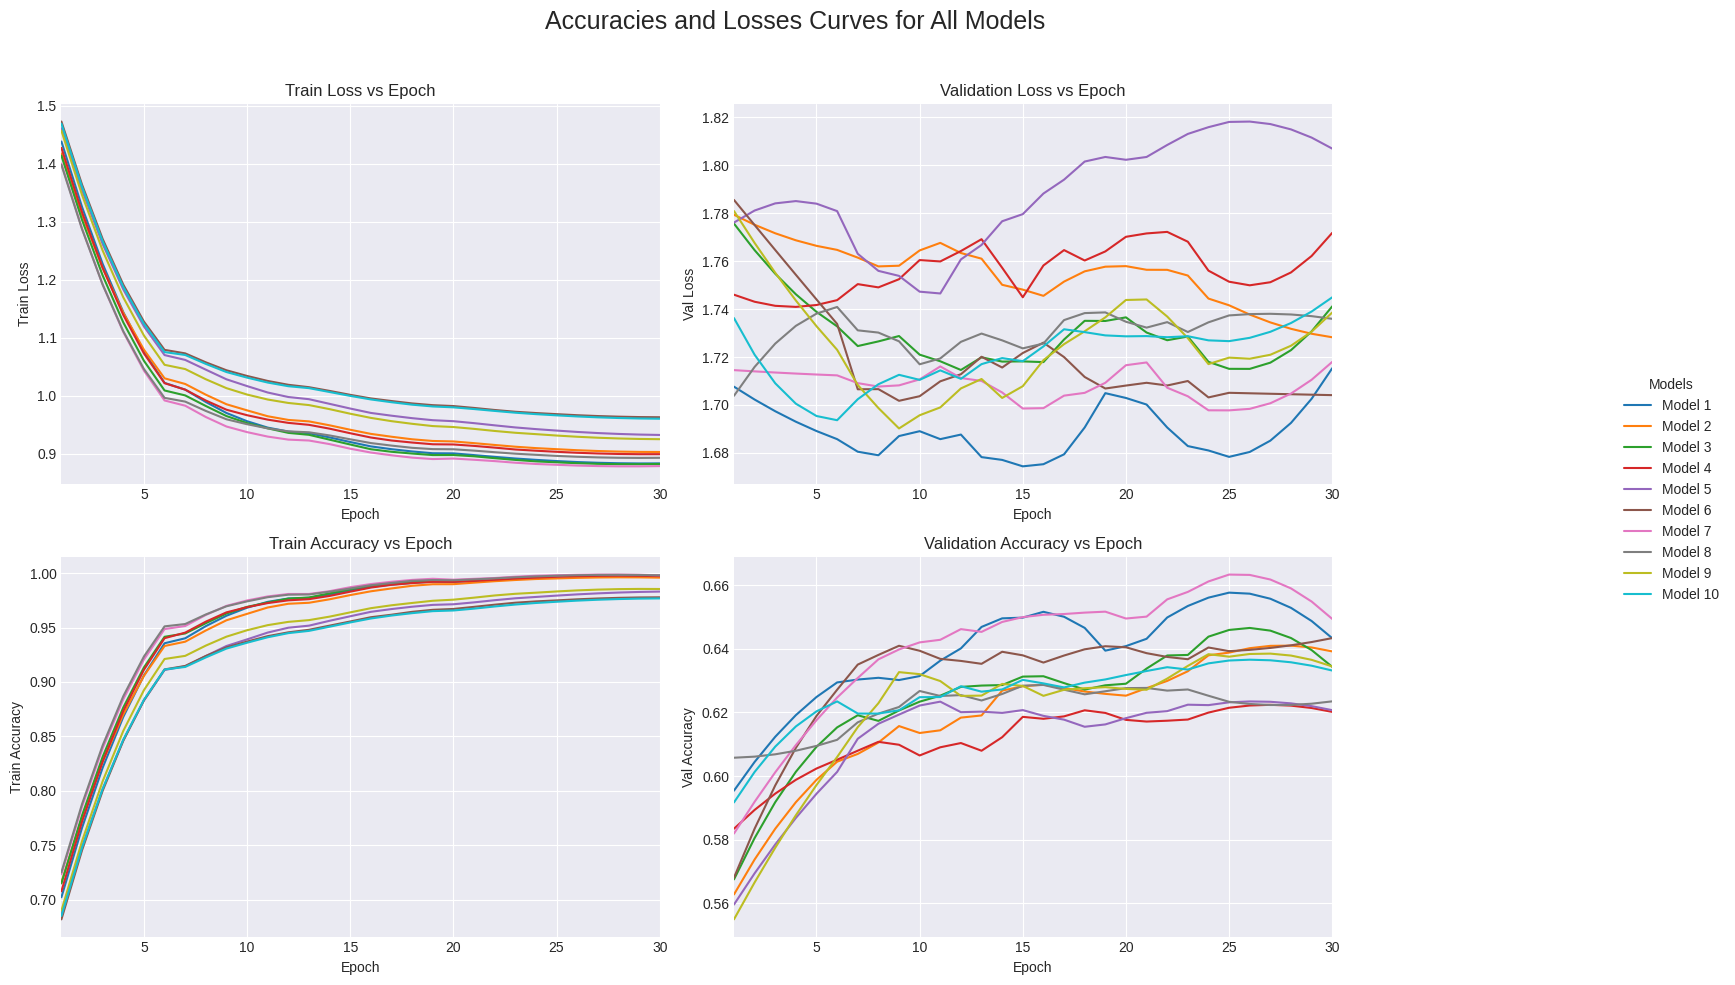

In [27]:
# Set plot style
plt.style.use("seaborn-darkgrid")

# Define colors (for up to 10 models)
colors = plt.cm.tab10(np.linspace(0, 1, len(all_model_data)))

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
(ax1, ax2), (ax3, ax4) = axs

def smooth_curve(y, window=11, poly=2):
    """Apply heavy Savitzky-Golay smoothing."""
    if len(y) < window:
        window = len(y) if len(y) % 2 == 1 else len(y) - 1
    if window < 3:
        return y
    return savgol_filter(y, window_length=window, polyorder=poly)

for i, model_data in enumerate(all_model_data):
    epochs = [e['epoch'] for e in model_data['epochs']]
    train_loss = [e['train_loss'] for e in model_data['epochs']]
    val_loss = [e['val_loss'] for e in model_data['epochs']]
    train_acc = [e['train_acc'] for e in model_data['epochs']]
    val_acc = [e['val_acc'] for e in model_data['epochs']]

    # Apply strong smoothing
    train_loss_smooth = smooth_curve(train_loss, window=11, poly=2)
    val_loss_smooth = smooth_curve(val_loss, window=11, poly=2)
    train_acc_smooth = smooth_curve(train_acc, window=11, poly=2)
    val_acc_smooth = smooth_curve(val_acc, window=11, poly=2)

    label = f"Model {model_data['model_number']}"

    ax1.plot(epochs, train_loss_smooth, label=label, color=colors[i])
    ax2.plot(epochs, val_loss_smooth, label=label, color=colors[i])
    ax3.plot(epochs, train_acc_smooth, label=label, color=colors[i])
    ax4.plot(epochs, val_acc_smooth, label=label, color=colors[i])

# Titles and axis labels
ax1.set_title("Train Loss vs Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")

ax2.set_title("Validation Loss vs Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Val Loss")

ax3.set_title("Train Accuracy vs Epoch")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Train Accuracy")

ax4.set_title("Validation Accuracy vs Epoch")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Val Accuracy")

# Format axes
for ax in axs.flatten():
    ax.set_xlim([1, max(epochs)])
    ax.grid(True)

# Move legend to right side
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5), title="Models")

plt.suptitle("Accuracies and Losses Curves for All Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()